#COVID
<font color='orange'>**If you attended the class in person, please don't forget to fill in [this form](https://docs.google.com/forms/d/e/1FAIpQLSfA7p1lxOhaXLw_2jO1OBvOzqheS0kjzm968S4uciXQKh5__g/viewform)**

# Introduction to unsupervised learning 

Please, make a copy of this colaboratory in order to be able to make changes **(File -> Save a copy in Drive)**.


## Homework #2

This colaboratory also contains Homework #2 which is due **October 4 midnight (23:59 EET time)**. To complete the homework, extract **(File -> Download .ipynb)** and submit to the course webpage.

**NB! Links to your colaboratory will not be accepted as a solution!**

##List of Homework's tasks:

1.   [Ex1](#scrollTo=tz9XASPxeqDC) - 2 points
2.   [Ex2](#scrollTo=1YXt-Gxw9UY7) - 5 points
3.   [Ex3](#scrollTo=mOR5SzdHYetB) - 3 points
4.   [Bonus 1](#scrollTo=93rYhdhm3by8) - 0.5 points
5.   [Bonus 2](#scrollTo=IhIMUQjs3bzV) -  0.5 points
6.   [Bonus 3](#scrollTo=-hm9PvBXZD0R) - 4 points



## Setup: 
Here we will load necessary libraries (NumPy, Pandas and loading and visualising MNIST handwritten digits)

In [1]:
# The three giants on which everything else is built
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Ready made stuff lives here:
import sklearn
from sklearn.neighbors import KNeighborsClassifier

# We don't like warnings
import warnings
warnings.filterwarnings('ignore')

# For plotting like a pro
!pip install plotnine
from plotnine import *

# Not sure why we need this
import os

# old school TF 
# - we do not "learn TF1", we use it just to get to MNIST
%tensorflow_version 1.x

# Supress warnings by TF 1.x
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# MNIST lives here:
from tensorflow.examples.tutorials.mnist import input_data

TensorFlow 1.x selected.


# Curse of dimensionality (part I)
Distances in high dimensional spaces become more similar (MNIST example)

In [2]:
# exactly the same as in previous practice session
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
images = mnist.train.images
labels = mnist.train.labels
print(f"images are of shape: {images.shape} and labels: {labels.shape}")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
images are of shape: (55000, 784) and labels: (55000,)


Taking a subsample again, just to make things run a bit faster

In [3]:
train_images = images[0:2000,:]
train_labels = labels[0:2000]

test_images = images[2000:3000,:]
test_labels = labels[2000:3000]

In [4]:
# function from the previous practice session
# finds euclidean distance between two images
def dist(img1, img2):
  return(np.sqrt(np.sum(np.abs(img1 - img2)**2)))

In [5]:
dist(train_images[0], train_images[1])

11.858396

Let's calculate euclidean distances between all images in the training data using `dist()` function by running the following cell.

In [6]:
%%time
# Initialize the matrix with zeros
distanceMatrix = np.zeros((len(train_images), len(train_images)))

##### YOUR CODE STARTS #####
for i in np.arange(len(train_images)):
  for j in np.arange(len(train_images)):
    if i == j:
      distanceMatrix[i,j] = float('inf') # to make sure that image is not the closest to itself
    else:
      distanceMatrix[i,j] = dist(train_images[i], train_images[j])
##### YOUR CODE ENDS ##### (please do not delete this line)


CPU times: user 47.1 s, sys: 380 µs, total: 47.1 s
Wall time: 47.1 s


In [7]:
distanceMatrix[0:5,0:5]

array([[        inf, 11.85839558, 10.92733383, 10.70416069, 10.89945316],
       [11.85839558,         inf,  8.58878231, 10.87264538,  9.65340614],
       [10.92733383,  8.58878231,         inf,  9.80678082, 10.10799885],
       [10.70416069, 10.87264538,  9.80678082,         inf,  8.86838913],
       [10.89945316,  9.65340614, 10.10799885,  8.86838913,         inf]])

NumPy has a function `np.linalg.norm()` that can help calculate eucledian distance between images. More information about the function can be found here: https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html. This function is a lot more efficient than our own code and also we are lazy :)

In [8]:
np.linalg.norm(train_images[0] - train_images[1])

11.858396

Let's calculate euclidean distances between all images in the training data and store them in a matrix using `np.linalg.norm()` function.

In [9]:
%%time
distanceMatrix = np.array([np.linalg.norm(image - train_images[:], axis=-1) for image in train_images])
distanceMatrix[np.diag_indices(distanceMatrix.shape[0])] = float('inf')

CPU times: user 6.45 s, sys: 116 ms, total: 6.57 s
Wall time: 6.57 s


In [10]:
distanceMatrix[0:5,0:5]

array([[      inf, 11.858396, 10.927334, 10.704161, 10.899453],
       [11.858396,       inf,  8.588782, 10.872645,  9.653406],
       [10.927334,  8.588782,       inf,  9.806781, 10.107999],
       [10.704161, 10.872645,  9.806781,       inf,  8.868389],
       [10.899453,  9.653406, 10.107999,  8.868389,       inf]],
      dtype=float32)

Here comes weirdly looking and hard to understand code that takes a random image from `train_images` and prints out a series of images that are closest in the euclidean space.

In [11]:
plt.rcParams['figure.figsize'] = (24.0, 12.0) # set default size of plots
# "Names" of classes:
classes =  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

def plot_random_sequence(start_id):
  print(start_id)
  n_images = 30

  plt.subplot(1, 1, 1)
  plt.imshow(train_images[start_id].reshape((28, 28)), plt.get_cmap('gray'))
  plt.axis('off')

  curr_id = start_id
  idx = np.zeros(n_images)
  idx[0] = curr_id
  new_id = -1

  for i in (np.arange(1, n_images)):
    plt_idx = i
    plt.subplot(1, n_images, (plt_idx + 1))
    closest_idx = np.argsort(distanceMatrix[:,curr_id].flatten())
    
    for j in closest_idx:
      if not j in idx:
        new_id = j
        break
    
    if new_id == -1:
      break

    plt.imshow(train_images[new_id].reshape((28, 28)), plt.get_cmap('gray'))
    plt.axis('off')
    plt.title(train_labels[new_id])
    curr_id = new_id
    idx[i] = curr_id
    new_id = -1

  plt.show()

Play around with the output by re-running this cell miltiple times.

678


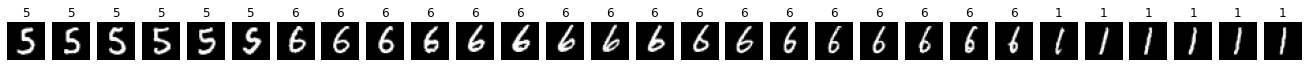

In [12]:
##### YOUR CODE STARTS #####
start_id = 678  # 21,678 are interesting cases
##### YOUR CODE ENDS ##### (please do not delete this line)
plot_random_sequence(start_id)

Next we can see couple of images that are on the equal distances from each other in the euclidean space

In [13]:
np.append(np.array(0), np.where(np.round(distanceMatrix[0,:], 1) == 8.6)[0])

array([   0, 1234, 1588, 1590, 1866])

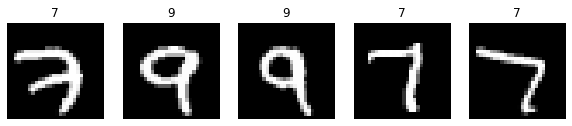

In [14]:
ids = np.append(np.array(0), np.where(np.round(distanceMatrix[0,:], 1) == 8.6)[0])

plt.rcParams['figure.figsize'] = (10, 8.0) # set default size of plots

for i in np.arange(len(ids)):
  plt_idx = i
  plt.subplot(1, len(ids), plt_idx + 1)
  plt.imshow(train_images[ids[i]].reshape((28, 28)), plt.get_cmap('gray'))
  plt.axis('off')
  plt.title(train_labels[ids[i]])

plt.show()

# Curse of dimensionality (part II)
Here we will illustrate how increasing the dimensionality of your data (adding more features) may impact the performance of the machine learning model.

We generate 100 points from 50 dimensional Gaussian distribution. Fifty points are generated from a distribution centered at 1 and another fifty from a distribution with a centre in 0.

In [15]:
np.random.seed(2342347823) # random seed for consistency

D = 50
num_points = 50

# Generating 50 points for the first class
mu_vec1 = np.zeros(D) 
cov_mat1 = np.eye(D) # creates a diagonal matrix of size D x D, all values except diagonal are 0
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, num_points)

# Generating 50 points for the second class
mu_vec2 = np.ones(D) # this is the only difference with the previous matrix
cov_mat2 = np.eye(D)
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, num_points)

In [16]:
print(class1_sample.shape)
print(class2_sample.shape)

(50, 50)
(50, 50)


Combine two samples together into one dataset

In [17]:
data = np.concatenate((class1_sample, class2_sample), axis=0)
train_data = pd.DataFrame(data)
train_data.shape

(100, 50)

In [18]:
# Create names for columns, x1, x2 ... x50
train_data.columns = [ 'x' + str(i) for i in (np.arange(D)+1)]
print(train_data.columns)

Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21',
       'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31',
       'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41',
       'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50'],
      dtype='object')


In [19]:
# Create a class column
train_data['class'] = np.concatenate((np.repeat(0, num_points), np.repeat(1, num_points)))
print(train_data['class'])

0     0
1     0
2     0
3     0
4     0
     ..
95    1
96    1
97    1
98    1
99    1
Name: class, Length: 100, dtype: int64


In [20]:
# This is important for plotting and modelling
train_data['class'] = train_data['class'].astype('category')
print(train_data['class'])

0     0
1     0
2     0
3     0
4     0
     ..
95    1
96    1
97    1
98    1
99    1
Name: class, Length: 100, dtype: category
Categories (2, int64): [0, 1]


Divide this dataset into two sets: training set (60%) and validation set (40%). As we have done in the previous practice.

In [21]:
##### YOUR CODE STARTS #####
train = train_data[:int(len(train_data)*0.6)]
val = train_data[int(len(train_data)*0.6):]
##### YOUR CODE ENDS ##### (please do not delete this line)

In [22]:
print(train.shape)
print(val.shape)

(60, 51)
(40, 51)


Visualise training data

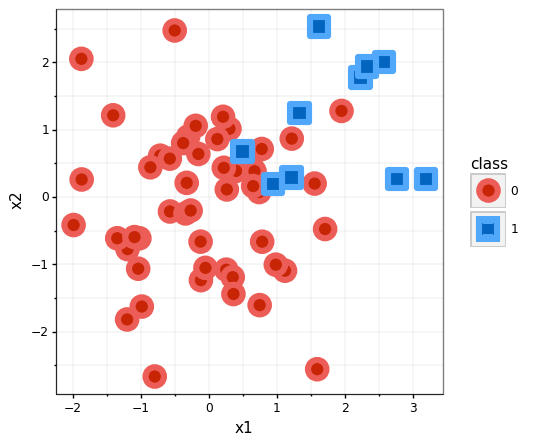

<ggplot: (8778894329706)>

In [23]:
fig = (
    ggplot(data = train,
          mapping = aes(x = 'x1', y = 'x2')) +
    geom_point(aes(colour = 'class', 
                   shape = 'class',
                   fill = 'class'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x1',
        y = 'x2',
    ) +
    theme_bw() + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig 

There are way more instances on the class 0 than instances of class 1. What is wrong?

In [24]:
train_data

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,class
0,0.747677,-1.607201,1.522674,-0.319540,0.752203,1.557956,-0.463461,-0.669275,0.473778,0.739542,1.589954,0.442445,-0.004909,-0.046979,0.397892,-1.294606,0.694133,0.342759,-1.441115,-0.737550,0.176028,1.648736,-1.472942,-0.058913,-0.420940,-1.631126,1.856534,-0.242551,-0.561936,-1.730037,0.505550,-0.936961,0.540934,-1.207821,-0.195721,-1.487145,1.136321,1.137363,1.331009,-1.464451,-1.572992,-1.441759,-0.459967,-0.751401,-0.806643,-0.859542,-0.349027,-0.251280,0.633352,-0.399698,0
1,1.219613,0.868021,-0.619240,0.351791,1.201451,0.062275,1.210506,-0.303558,0.882985,0.044489,1.341507,-0.117888,-0.108053,0.278860,-0.025774,0.099960,-0.783417,-0.438270,-0.659739,-2.105046,0.217625,1.068660,-0.219409,0.025689,1.479508,-0.406201,-0.547503,0.496417,0.931444,0.668112,-0.261571,0.748211,-0.375374,0.502511,-0.686963,1.766523,1.350128,1.167129,-0.788339,0.709485,0.320224,1.343128,-1.106933,-0.085820,0.547569,-0.494705,0.956354,-0.932077,-0.460074,-0.788092,0
2,-1.195929,-0.774669,0.696410,1.061209,-0.410439,-0.008696,0.564533,0.350594,-1.116167,-0.318810,-0.659029,-1.045056,-1.707577,-1.257379,-1.431405,-1.852340,-0.648867,-1.516387,1.443972,1.512858,-0.044416,0.350676,-0.324716,1.212243,0.566808,-0.011266,0.162792,-0.206429,1.110316,-0.286406,0.991402,-0.194244,-0.854822,1.252368,-1.739109,-0.454751,-0.179062,-0.005480,-1.032001,-2.146083,-0.660793,0.263611,-1.717626,-0.185739,-0.560680,-0.498485,-0.532319,-0.995843,-0.909416,-1.416558,0
3,0.264414,0.112681,0.192169,0.355585,-0.865096,0.318052,0.006032,-0.061810,-2.095889,-0.418547,-0.935316,-0.808466,-1.829418,1.542496,-0.367826,-0.148362,-0.562442,0.375326,-0.320766,0.673503,-0.523584,-0.716604,0.185284,1.289590,-0.992946,0.140806,-1.188236,-0.475218,0.680918,1.544214,-0.575834,0.532910,0.509478,0.120585,0.315872,-0.058684,0.296975,0.101577,0.900854,-0.531233,-2.324148,-0.083450,0.167278,-2.786565,1.894240,0.738902,-1.656709,-0.621922,-0.267875,0.427367,0
4,1.120413,-1.095159,0.204777,-0.138254,0.880851,0.210507,-0.123610,0.493870,0.611769,0.250134,-1.263939,-0.511343,1.685723,-0.499306,-0.697102,0.652246,-0.197094,-0.030133,0.819985,0.613407,-1.643933,-0.143486,0.694045,-1.346329,0.353155,1.188062,-0.082800,-0.229194,-0.258877,0.882416,0.046846,-1.683481,-0.874930,-1.712196,-0.751601,0.372385,1.448325,1.647289,0.100085,0.578099,-1.213437,0.146685,0.027748,2.054341,-0.230407,0.266749,0.903898,-0.066085,0.427149,-0.661240,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.104919,1.252980,1.658231,1.941015,1.568226,-0.115000,2.196086,2.428435,0.644166,0.987869,1.210136,1.242484,1.397341,0.523204,0.737055,1.110152,1.790838,0.711254,1.532001,2.009027,2.328365,1.551124,-0.140181,1.226457,-0.438719,-0.080637,2.779536,-1.259176,1.182468,0.259412,1.681071,2.608355,-1.419734,0.069894,1.613240,-0.563164,0.032398,1.020047,0.758673,0.467802,1.137232,0.901980,0.913398,2.562633,0.915908,1.874201,2.933346,0.255366,-0.075562,1.848119,1
96,1.992165,1.180438,0.530449,-0.552553,2.428961,1.239961,1.975958,0.614475,1.070003,0.051726,0.578562,0.394224,-0.114710,-0.419042,-0.546171,1.581940,0.822279,2.884147,0.201462,0.821273,1.001304,-0.866672,1.073762,0.353663,3.157986,0.035995,1.028554,2.079344,2.054601,0.259372,1.980353,1.311019,3.113103,1.462325,0.113167,0.870078,0.492532,1.128999,0.580355,0.615590,0.118621,-0.486802,0.340942,-0.011111,-1.232585,0.841310,2.514729,1.722143,-0.522049,-0.203944,1
97,1.998636,1.726255,2.671475,1.112760,0.771333,0.854221,2.209769,-0.914055,-1.413485,0.552039,0.024382,1.101465,-0.320646,2.161776,1.296302,1.253355,1.638177,0.370946,0.557408,0.834159,1.072859,2.165636,-0.763010,0.952966,1.614026,0.255262,2.374882,1.198770,1

In [25]:
from sklearn.model_selection import train_test_split
##### YOUR CODE STARTS #####
train, val = train_test_split(train_data, test_size = 0.4, random_state=111)
##### YOUR CODE ENDS ##### (please do not delete this line)

Visualise the training data again to make sure that now we managed to get balanced representation

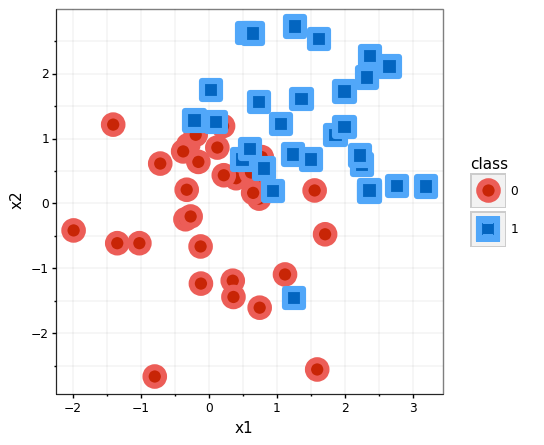

<ggplot: (-9223363257960524372)>

In [26]:
fig = (
    ggplot(data = train,
          mapping = aes(x = 'x1', y = 'x2')) +
    geom_point(aes(colour = 'class', 
                   shape = 'class',
                   fill = 'class'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x1',
        y = 'x2',
    ) +
    theme_bw() + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig 

Well done! What about the validation set?

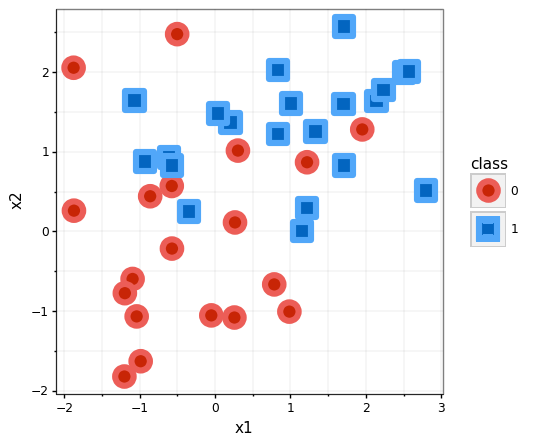

<ggplot: (8778894278078)>

In [27]:
fig = (
    ggplot(data = val,
          mapping = aes(x = 'x1', y = 'x2')) +
    geom_point(aes(colour = 'class', 
                   shape = 'class',
                   fill = 'class'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x1',
        y = 'x2',
    ) +
    theme_bw() + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig 

Let's see how the Decision Tree algorithm can cope with this data. Let's import the Decision Tree (this time we will need classifier) from the `sklearn` package.

In [28]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth = 5) 

Train a DecisionTreeClassifier on 2D data and test it on validation data (we shall not use CV algorithm in this case to save time)

In [29]:
np.random.seed(1111)
# Training DecisionTreeClassifier on 2D data
model.fit(X = train[['x1', 'x2']], y = train['class'])

##### YOUR CODE STARTS #####
val_predict = model.predict(X = val[['x1', 'x2']])

# Calculate accuracy of the prediction
val_accuracy = np.mean(val_predict == val['class'])
##### YOUR CODE ENDS ##### (please do not delete this line)

print(f"Validation accuracy is {val_accuracy*100}%")

Validation accuracy is 80.0%


Now let's do the same for 5D and 50D data

In [30]:
np.random.seed(1111)
# Training the same model on 5D data
model.fit(X = train.iloc[:,:5], y = train['class'])

##### YOUR CODE STARTS #####
val_predict = model.predict(X = val.iloc[:,:5])
val_accuracy = np.mean(val_predict == val['class'])
##### YOUR CODE ENDS ##### (please do not delete this line)

print(f"Validation accuracy is {val_accuracy*100}%")

Validation accuracy is 72.5%


In [31]:
np.random.seed(1111)
##### YOUR CODE STARTS #####
# Training on 50D data
model.fit(X = train.iloc[:,:50], y = train['class'])
val_predict = model.predict(X = val.iloc[:,:50])
val_accuracy = np.mean(val_predict == val['class'])
##### YOUR CODE ENDS ##### (please do not delete this line)

print(f"Validation accuracy is {val_accuracy*100}%")

Validation accuracy is 65.0%


What is going on here? Let's visualise our validation set along with predicted classes.

In [32]:
np.random.seed(1111)
model.fit(X = train[['x1','x2']], y = train['class'])

# 2D data
val_predict = model.predict(X = val[['x1','x2']])
val_accuracy = np.mean(val_predict == val['class'])

print(f"Validation accuracy is {val_accuracy*100}%")

# Adding results to validation set
val['predicted'] = val_predict
val['predicted'] = val['predicted'].astype('category')

Validation accuracy is 80.0%


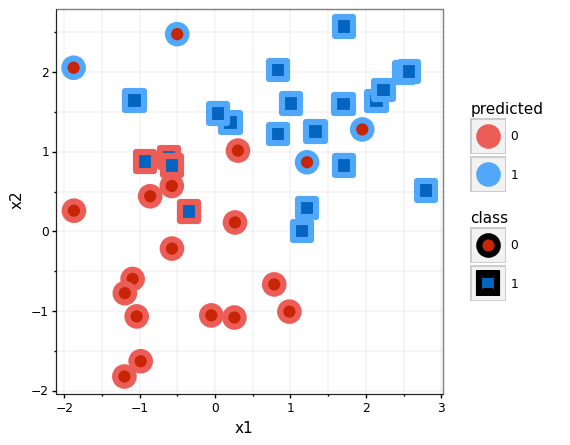

<ggplot: (8778893408923)>

In [33]:
fig = (
    ggplot(data = val,
          mapping = aes(x = 'x1', y = 'x2')) +
    geom_point(aes(colour = 'predicted', 
                   shape = 'class',
                   fill = 'class'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x1',
        y = 'x2',
    ) +
    theme_bw() + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig 

# Curse of dimensionality (part III)
The assumption is that under the curse of dimensionality the expected smallest distance between points increases (points in high-dimensional space are further apart) exponentially with number of dimensions. Here we will try to demonstrate this phenomenon experimentaly. 

Let's sample 14 points from 1D uniform distribution:


In [34]:
np.random.seed(1111)
oneD = np.random.rand(14,1) # samples from [0,1]
print(oneD)

[[0.0955492 ]
 [0.9250037 ]
 [0.34357342]
 [0.31047694]
 [0.00200984]
 [0.23559472]
 [0.23779172]
 [0.73591587]
 [0.49546808]
 [0.78442535]
 [0.12650631]
 [0.60664932]
 [0.46612097]
 [0.23713212]]


In [35]:
oneD = oneD*6 # here I multiply by 6 just to force values into a range from [0, 6]
print(oneD)

[[0.5732952 ]
 [5.55002221]
 [2.06144054]
 [1.86286165]
 [0.01205904]
 [1.41356835]
 [1.42675032]
 [4.41549524]
 [2.97280846]
 [4.70655209]
 [0.75903787]
 [3.63989592]
 [2.79672585]
 [1.42279275]]


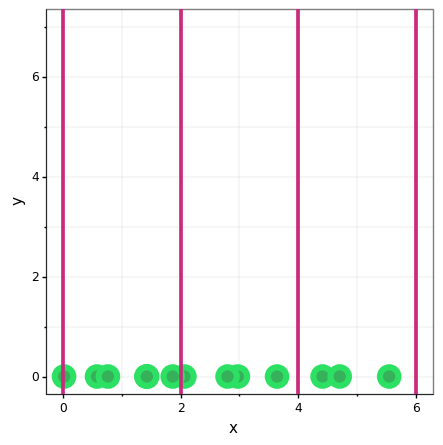

<ggplot: (8778894252594)>

In [36]:
# Converting oneD into pandas DataFrame before visualising
example_data = pd.DataFrame({'x':np.transpose(oneD)[0], 'y':np.zeros_like(np.transpose(oneD)[0])})

fig = (
    ggplot(data = example_data,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(fill = '#36B059', 
               size = 5.0,
               stroke = 2.5,
               colour = '#2BE062',
               shape = 'o') +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    xlim(0, 6) +
    ylim(0, 7) +
    theme_bw() + 
    geom_vline( xintercept = (0, 2, 4, 6), color="#CB297B", size=1.5) + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig 

Again sampling 14 points, now from uniform 2D distribution

In [37]:
np.random.seed(1111)
twoD = np.random.rand(14,2)*6

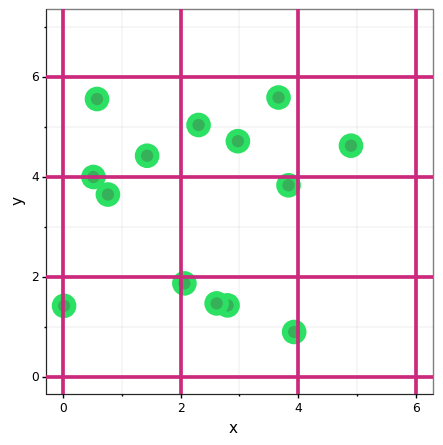

<ggplot: (-9223363257961421445)>

In [38]:
example_data = pd.DataFrame({'x':np.transpose(twoD)[0], 'y':np.transpose(twoD)[1]})
fig = (
    ggplot(data = example_data,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(fill = '#36B059', 
               size = 5.0,
               stroke = 2.5,
               colour = '#2BE062',
               shape = 'o') +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    xlim(0, 6) +
    ylim(0, 7) +
    theme_bw() + 
    geom_vline( xintercept = (0, 2, 4, 6), color="#CB297B", size=1.5) + 
    geom_hline( yintercept = (0, 2, 4, 6), color="#CB297B", size=1.5) +
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

Let's calculate and compare minimum dsistances between points in 1D and 2D.

In [39]:
oneD_distances = np.array([np.linalg.norm(point - oneD[:], axis=-1) for point in oneD])
print(oneD_distances.shape)
print(oneD_distances[:5,:5])

(14, 14)
[[0.         4.97672702 1.48814534 1.28956646 0.56123616]
 [4.97672702 0.         3.48858167 3.68716056 5.53796317]
 [1.48814534 3.48858167 0.         0.19857889 2.0493815 ]
 [1.28956646 3.68716056 0.19857889 0.         1.85080261]
 [0.56123616 5.53796317 2.0493815  1.85080261 0.        ]]


We will use `triu_indices` function (with an offset 1 from the main diagonal) to extract upper triangle of the distance matrix and take minimum of these

In [40]:
min1D_distance = np.min(oneD_distances[np.triu_indices(len(oneD), k = 1)])
print(min1D_distance)

0.00395757460194357


Let's do the same procedure for 2D points (`twoD`):

In [41]:
##### YOUR CODE STARTS #####
twoD_distances = np.array([np.linalg.norm(point - twoD[:], axis=-1) for point in twoD])
min2D_distance = np.min(twoD_distances[np.triu_indices(len(twoD), k = 1)])
##### YOUR CODE ENDS ##### (please do not delete this line)
print(min2D_distance)

0.18986906975559767


It has increased by at least one order of magnitude!

Make a function that samples a given number of points with a fixed number of dimensions from the random distribution and then calculates the minimum distance between these points (copy and paste from already created code).

In [42]:
##### YOUR CODE STARTS #####
def compute_min_distance(n_points, n_dimensions):
  points = np.random.rand(n_points,n_dimensions)*6
  distances = np.array([np.linalg.norm(point - points[:], axis=-1) for point in points])
  min_distance = np.min(distances[np.triu_indices(len(points), k = 1)])
  return(min_distance)
##### YOUR CODE ENDS ##### (please do not delete this line)


What about minimum smallest distance between points in 3D space?

In [43]:
min3D_distance = compute_min_distance(14, 3)
print(min3D_distance)

0.9479161947271668


In [44]:
 l = {}
 for i in np.arange(100):
   d1 = np.random.rand(14,2)*6
   d2 = np.array([np.linalg.norm(point - twoD[:], axis=-1) for point in twoD])
   l = np.min(d2[np.triu_indices(len(twoD), k = 1)])
l

0.18986906975559767

## Homework exercise 1 (2 points): Curse of dimensionality applied to sampling density

<font color='red'>**(Homework exercise 1- a)** When dealing with sampling random distributions one needs to be careful as variation between samples can be very large. Compute minimum distance in each space (1D, 2D and 3D) at least 1000 times. Store minimum distances from each space in its own variable (mins1D, mins2D and mins3D). For each space report the average smallest distance and confirm that these distances grow with number of dimensions. (1 point) </font> 

In [45]:
##### YOUR CODE STARTS #####
n_runs = 1000

# initialise the following arrays
mins1D = {}
mins2D = {}
mins3D = {}

for i in np.arange(n_runs):
  # oneD_points= np.random.rand(14,1)*6
  # twoD_points= np.random.rand(14,2)*6
  # threeD_point= np.random.rand(14,3)*6
  # distances_oneD = np.array([np.linalg.norm(point - oneD_points[:], axis=-1) for point in oneD_points])
  # distances_twoD = np.array([np.linalg.norm(point - twoD_points[:], axis=-1) for point in twoD_points])
  # distances_threeD = np.array([np.linalg.norm(point - threeD_point[:], axis=-1) for point in threeD_point])
  # mins1D = np.min(distances_oneD[np.triu_indices(len(oneD_points), k = 1)])
  # mins2D = np.min(distances_twoD[np.triu_indices(len(twoD_points), k = 1)])
  # mins3D = np.min(distances_threeD[np.triu_indices(len(threeD_point), k = 1)])
  mins1D = compute_min_distance(14,1)
  mins2D = compute_min_distance(14,2)
  mins3D = compute_min_distance(14,3)


##### YOUR CODE ENDS ##### (please do not delete this line)

print(f'the average smallest distance in 1D is {np.mean(mins1D)}')
print(f'the average smallest distance in 2D is {np.mean(mins2D)}')
print(f'the average smallest distance in 3D is {np.mean(mins3D)}')

the average smallest distance in 1D is 0.02644712431146612
the average smallest distance in 2D is 0.15447018816778674
the average smallest distance in 3D is 1.239306495132219


<font color='red'>**(Homework exercise 1- b)** According to elements of statistical learning (https://web.stanford.edu/~hastie/Papers/ESLII.pdf), sampling density is proportional to N^D. Therefore If we want to have the same expected smallest distance between points in 2D as we had in 1D space with 14 points (~0.02), we would need to generate 14^2 points (196 points) in 2D or 14^3 in 3D. Test this hypothesis by sampling corresponding number of points in each space and calculating the average smallest distances. (0.5 points) </font>


NB! probably it makes sense to decrease the number of runs to ~100.

In [46]:
##### YOUR CODE STARTS #####
n_runs = 100
mins1D = {}
mins2D = {}
mins3D = {}

for i in np.arange(n_runs):
  mins1D = compute_min_distance(14,1)
  mins2D = compute_min_distance(196,2)
  mins3D = compute_min_distance(2744,3)
##### YOUR CODE ENDS ##### (please do not delete this line)

print(f'the average smallest distance in 1D is {np.mean(mins1D)}')
print(f'the average smallest distance in 2D is {np.mean(mins2D)}')
print(f'the average smallest distance in 3D is {np.mean(mins3D)}')


the average smallest distance in 1D is 0.006645378707835992
the average smallest distance in 2D is 0.016632633532207418
the average smallest distance in 3D is 0.031913883267297376


<font color='red'>**(Homework exercise 1- c)** Interpret the obtained results. (0.5 points) </font>

Answer to **(c)**: I think that the rule applys for example on the first and second dimentions has a really close distances but in the third dimention the average smallest distance is a lot lower but that comes back to the fact that we are using randome values. I happen to run it several times and there were times where the second and third distances were a match so Yes the hypothesis is correct. 

# Principle Component Analysis (toy data)
Generate data from the lecture slides

In [47]:
Z = pd.DataFrame({'x':[1,2,3,4,5], 'y':[2,4,5,4,5]})

# Centering both features
Z.x = Z.x - Z.x.mean()
Z.y = Z.y - Z.y.mean()

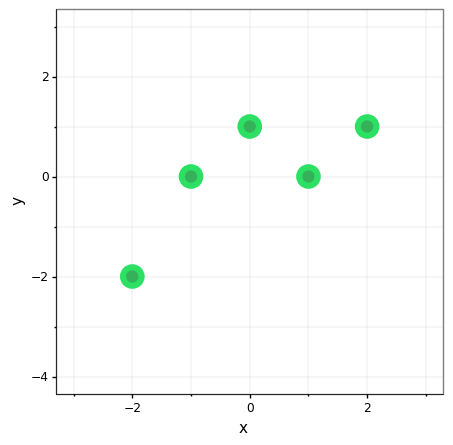

<ggplot: (-9223363257961421431)>

In [48]:
fig = (
    ggplot(data = Z,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(fill = '#36B059', 
               size = 5.0,
               stroke = 2.5,
               colour = '#2BE062',
               shape = 'o') +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    xlim(-3, 3) +
    ylim(-4, 3) +
    theme_bw() + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

Transpose the matrix of original coordinates

In [49]:
Z = np.matrix(Z)
Z_t = Z.T
print(Z)
print(Z_t)

[[-2. -2.]
 [-1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 2.  1.]]
[[-2. -1.  0.  1.  2.]
 [-2.  0.  1.  0.  1.]]


Compute covariance matrix

In [50]:
##### YOUR CODE STARTS #####
S = np.dot(Z_t, Z)/4
##### YOUR CODE ENDS ##### (please do not delete this line)
print(S)    

[[2.5 1.5]
 [1.5 1.5]]


Perform eigendecomposition using `linalg.eig` function from `numpy`

In [51]:
eigenvalues, eigenvectors = np.linalg.eig(S)
print(eigenvalues)
print(-1*eigenvectors)

[3.58113883 0.41886117]
[[-0.81124219  0.58471028]
 [-0.58471028 -0.81124219]]


Transform transposed matrix of original coordinates into the space of principle components.

In [52]:
Z_new = np.dot((-1*eigenvectors).T, Z_t) # we multiple with -1 just to make results look exactly like in lecture :)

# Make it actually look nice
Z_new_pd = pd.DataFrame({'PC1':np.array(Z_new)[0], 'PC2':np.array(Z_new)[1]})
print(Z_new_pd)

        PC1       PC2
0  2.791905  0.453064
1  0.811242 -0.584710
2 -0.584710 -0.811242
3 -0.811242  0.584710
4 -2.207195  0.358178


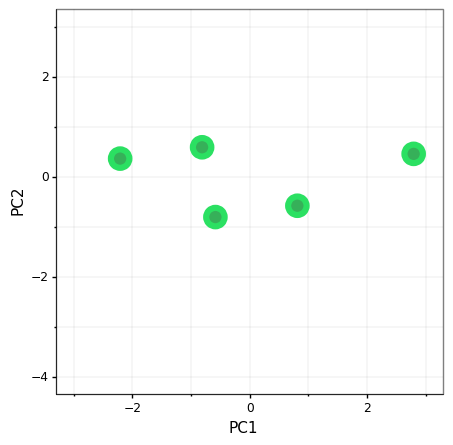

<ggplot: (8778893324429)>

In [53]:
fig = (
    ggplot(data = Z_new_pd,
          mapping = aes(x = 'PC1', y = 'PC2')) +
    geom_point(fill = '#36B059', 
               size = 5.0,
               stroke = 2.5,
               colour = '#2BE062',
               shape = 'o') +
    labs(
        title ='',
        x = 'PC1',
        y = 'PC2',
    ) +
    xlim(-3, 3) +
    ylim(-4, 3) +
    theme_bw() + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

## PCA with `sklearn`
Of course, you guessed it, `sklearn` can do it for you.

In [54]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) #choose the number of components = number of original dimensions

# use PCA on our data
pca.fit(Z)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [55]:
dir(pca)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_fit',
 '_fit_full',
 '_fit_svd_solver',
 '_fit_truncated',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 'components_',
 'copy',
 'explained_variance_',
 'explained_variance_ratio_',
 'fit',
 'fit_transform',
 'get_covariance',
 'get_params',
 'get_precision',
 'inverse_transform',
 'iterated_power',
 'mean_',
 'n_components',
 'n_components_',
 'n_features_',
 'n_samples_',
 'noise_variance_',
 'random_state',
 'score',
 'score_samples',
 'set_params',
 'singular_values

In [56]:
pca_eigenvectors = pca.components_

##### YOUR CODE STARTS #####
pca_eigenvalues = pca.explained_variance_
##### YOUR CODE ENDS ##### (please do not delete this line)

print(pca_eigenvectors)
print(pca_eigenvalues)

[[-0.81124219 -0.58471028]
 [-0.58471028  0.81124219]]
[3.58113883 0.41886117]


Transform the original matrix with `sklearn` derived values:

In [57]:
##### YOUR CODE STARTS #####
Z_new = np.dot((pca_eigenvectors), Z_t) # note that here we don't need to transpose eigenvectors
##### YOUR CODE ENDS ##### (please do not delete this line)

Z_new_pd = pd.DataFrame({'PC1':np.array(Z_new)[0], 'PC2':(-1*np.array(Z_new)[1])})
print(Z_new_pd)

        PC1       PC2
0  2.791905  0.453064
1  0.811242 -0.584710
2 -0.584710 -0.811242
3 -0.811242  0.584710
4 -2.207195  0.358178


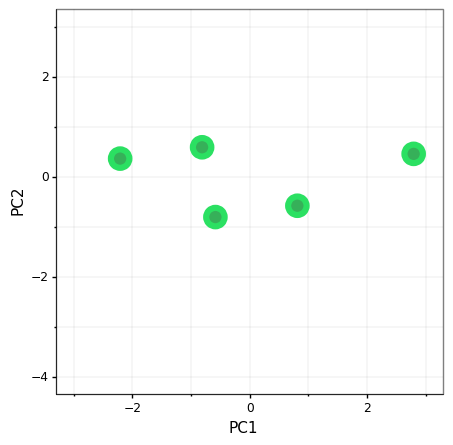

<ggplot: (8778893324387)>

In [58]:
fig = (
    ggplot(data = Z_new_pd,
          mapping = aes(x = 'PC1', y = 'PC2')) +
    geom_point(fill = '#36B059', 
               size = 5.0,
               stroke = 2.5,
               colour = '#2BE062',
               shape = 'o') +
    labs(
        title ='',
        x = 'PC1',
        y = 'PC2',
    ) +
    xlim(-3, 3) +
    ylim(-4, 3) +
    theme_bw() + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

## Shorter way to use PCA from `sklearn`

In [59]:
pca = PCA(n_components=2)
Z_new = pca.fit_transform(Z).T

That is it :)

In [60]:
Z_new_pd = pd.DataFrame({'PC1':np.array(Z_new)[0], 'PC2':(-1*np.array(Z_new)[1])})
print(Z_new_pd)

        PC1       PC2
0  2.791905  0.453064
1  0.811242 -0.584710
2 -0.584710 -0.811242
3 -0.811242  0.584710
4 -2.207195  0.358178


In [61]:
Z_new

array([[ 2.79190494,  0.81124219, -0.58471028, -0.81124219, -2.20719466],
       [-0.4530638 ,  0.58471028,  0.81124219, -0.58471028, -0.35817838]])

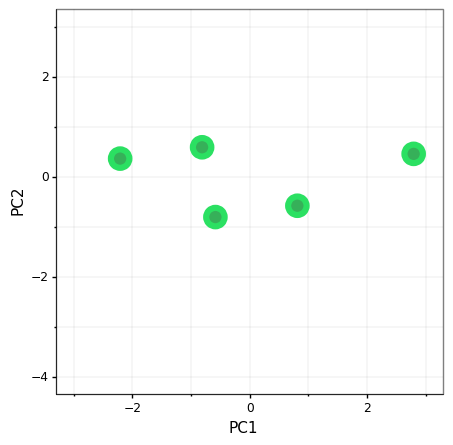

<ggplot: (-9223363257961525567)>

In [62]:
fig = (
    ggplot(data = Z_new_pd,
          mapping = aes(x = 'PC1', y = 'PC2')) +
    geom_point(fill = '#36B059', 
               size = 5.0,
               stroke = 2.5,
               colour = '#2BE062',
               shape = 'o') +
    labs(
        title ='',
        x = 'PC1',
        y = 'PC2',
    ) +
    xlim(-3, 3) +
    ylim(-4, 3) +
    theme_bw() + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

# PCA can improve ML performance on high-dimensional data
Let's see how PCA can help us first to compress the original 50D data and secondly enable the Decision Tree algorithm perform better.

First, some simple preprocessing.


In [63]:
# we need to drop class variable (we will still have it stored in train)
train_Z = train.drop('class', axis = 1)

# subtract mean from each column
train_Z = train_Z - train_Z.mean()

Let's do the PCA on training data

In [64]:
pca = PCA(n_components=D) # D was 50 when we generated the data

# Transform the original coordinates into PC space
train_Z_new = pca.fit_transform(train_Z).T

## Quantifying variance explained by PCs

Here, we will try to estimate the number of principle components that are needed to explain 90% of variance (read information) in our data. Let's print out `explained_variance_` attribute of our `pca` object.

In [65]:
print(np.round(pca.explained_variance_, 3))

[13.688  3.822  3.196  2.817  2.634  2.57   2.459  2.157  2.069  2.007
  1.821  1.691  1.564  1.477  1.466  1.451  1.337  1.223  1.194  1.107
  1.011  0.919  0.806  0.757  0.706  0.674  0.66   0.561  0.499  0.473
  0.436  0.395  0.366  0.35   0.285  0.276  0.252  0.201  0.185  0.171
  0.156  0.137  0.101  0.093  0.073  0.046  0.037  0.034  0.018  0.015]


Here we can calculate the total of the variance explained by all PCs

In [66]:
total_ev = np.sum(pca.explained_variance_)
print(total_ev)

62.443959093379874


We can divide each value by the sum of all variances to figure out the precentages

In [67]:
##### YOUR CODE STARTS #####
print(np.round(pca.explained_variance_/total_ev, 3))
##### YOUR CODE ENDS ##### (please do not delete this line)

[0.219 0.061 0.051 0.045 0.042 0.041 0.039 0.035 0.033 0.032 0.029 0.027
 0.025 0.024 0.023 0.023 0.021 0.02  0.019 0.018 0.016 0.015 0.013 0.012
 0.011 0.011 0.011 0.009 0.008 0.008 0.007 0.006 0.006 0.006 0.005 0.004
 0.004 0.003 0.003 0.003 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001
 0.    0.   ]


Or we can use a handy attribute `explained_variance_ratio_` to avoid this pain.

In [68]:
print(np.round(pca.explained_variance_ratio_, 3))

[0.219 0.061 0.051 0.045 0.042 0.041 0.039 0.035 0.033 0.032 0.029 0.027
 0.025 0.024 0.023 0.023 0.021 0.02  0.019 0.018 0.016 0.015 0.013 0.012
 0.011 0.011 0.011 0.009 0.008 0.008 0.007 0.006 0.006 0.006 0.005 0.004
 0.004 0.003 0.003 0.003 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001
 0.    0.   ]


How many PCs need to be retained in order to explain 90% or more variance of the original data?

In [69]:
variances = pca.explained_variance_ratio_

# Compute the array of total variances explained by 1, 2, 3, ... N components
com_vars = np.array([(np.sum(variances[:i])) for i in np.arange(len(variances))])

print(np.round(com_vars, 3))

[0.    0.219 0.28  0.332 0.377 0.419 0.46  0.499 0.534 0.567 0.599 0.628
 0.655 0.681 0.704 0.728 0.751 0.772 0.792 0.811 0.829 0.845 0.86  0.873
 0.885 0.896 0.907 0.917 0.926 0.934 0.942 0.949 0.955 0.961 0.967 0.971
 0.976 0.98  0.983 0.986 0.989 0.991 0.993 0.995 0.996 0.998 0.998 0.999
 0.999 1.   ]


In [70]:
##### YOUR CODE STARTS #####
# Get the smallest number of PCs that explains at least 90% of variance
smallest_pc_num = np.min(np.where(com_vars > 0.9))
##### YOUR CODE ENDS ##### (please do not delete this line)
print(f'The smallest number of PCs that explains more than 90% of variance is {smallest_pc_num} out of {len(pca.explained_variance_ratio_)}')

The smallest number of PCs that explains more than 90% of variance is 26 out of 50


Let's first visualise first two principle components

In [71]:
train_Z_new = pd.DataFrame({'PC1':np.array(train_Z_new)[0], 'PC2':np.array(train_Z_new)[1], 'class': train['class']})

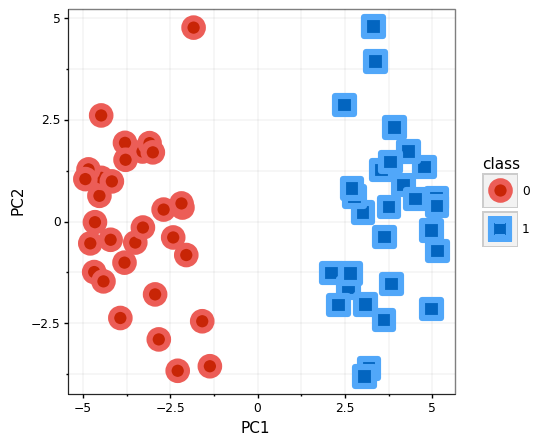

<ggplot: (8778893338039)>

In [72]:
fig = (
    ggplot(data = train_Z_new,
          mapping = aes(x = 'PC1', y = 'PC2')) +
    geom_point(aes(colour = 'class', 
                   shape = 'class',
                   fill = 'class'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'PC1',
        y = 'PC2',
    ) +
    theme_bw() + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig 

Performing with validation set all the same operations we performed on train

In [73]:
val_Z = val.drop(['class', 'predicted'], axis = 1)

# Normalisation
val_Z = val_Z - val_Z.mean()

# Apply PCA transform from train
val_Z_new = np.dot(pca.components_, val_Z.T)

# Save the results
val_Z_new = pd.DataFrame({'PC1':np.array(val_Z_new)[0], 'PC2':np.array(val_Z_new)[1], 'class': val['class']})

In [74]:
pca.components_

array([[ 0.18714186,  0.1803709 ,  0.11564486, ...,  0.14018024,
         0.08976989,  0.14640602],
       [-0.04890079,  0.14011372,  0.11082955, ..., -0.04450969,
         0.34384272,  0.40562702],
       [ 0.00955277, -0.16728439, -0.17397447, ...,  0.01156652,
        -0.10753045, -0.05053623],
       ...,
       [-0.0974027 ,  0.00578584, -0.03369085, ..., -0.11140947,
         0.14433945,  0.0842323 ],
       [ 0.0414909 ,  0.0832967 , -0.23378343, ..., -0.16642919,
         0.01100539,  0.09559106],
       [ 0.17377001, -0.14730972, -0.14815167, ...,  0.15748888,
        -0.15126958,  0.0562764 ]])

In [75]:
len(val_Z_new) , len(val_predict)

(40, 40)

Now we can train the model and test its accuracy on validation set

In [76]:
model = DecisionTreeClassifier(max_depth = 5) 

# train a model
model.fit(X = train_Z_new[['PC2']], y = train_Z_new['class'])

# predict validation set
val_predict = model.predict(val_Z_new[['PC2']])

# estimate the accuracy
val_accuracy = np.mean(val_predict == val_Z_new['class'])
print(f"Validation accuracy is {val_accuracy*100}%")

Validation accuracy is 52.5%


Wow, that is impressive, but kinda unbelievable, let's visualise! (seeing is believing)

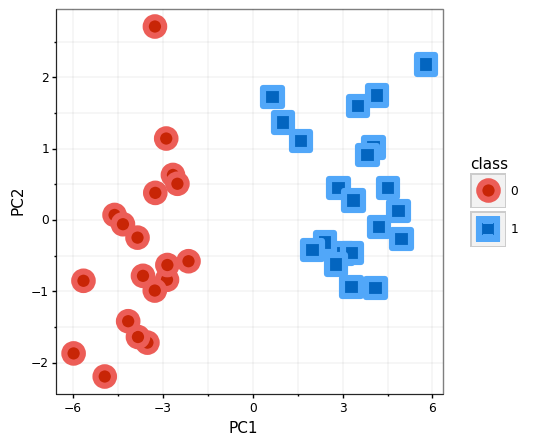

<ggplot: (8778893250175)>

In [77]:
fig = (
    ggplot(data = val_Z_new,
          mapping = aes(x = 'PC1', y = 'PC2')) +
    geom_point(aes(colour = 'class', 
                   shape = 'class',
                   fill = 'class'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'PC1',
        y = 'PC2',
    ) +
    theme_bw() + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig 

Not bad!

### Getting our raw data back after PCA

In [78]:
train_Z_new = pca.fit_transform(train_Z)
train_Z_new.shape

(60, 50)

In [79]:
pca.components_.T.shape

(50, 50)

In [80]:
# Conventional PCA
train_Z_new = pca.fit_transform(train_Z)

# Get original data back
train_Z_original = pca.inverse_transform(train_Z_new) 

print(np.round(train_Z_original, 2)[:5,:5])
np.matrix(np.round(train_Z, 2))[:5,:5]

[[ 0.   -2.09  1.02 -0.83  0.21]
 [-0.35 -0.1   0.78 -1.48 -2.33]
 [-0.86 -1.72 -0.39 -0.5  -0.67]
 [ 0.61  1.12  0.94  0.84  1.5 ]
 [ 0.52  2.24 -0.06  0.9   0.45]]


matrix([[ 0.  , -2.09,  1.02, -0.83,  0.21],
        [-0.35, -0.1 ,  0.78, -1.48, -2.33],
        [-0.86, -1.72, -0.39, -0.5 , -0.67],
        [ 0.61,  1.12,  0.94,  0.84,  1.5 ],
        [ 0.52,  2.24, -0.06,  0.9 ,  0.45]])

## Homework exercise 2 (5 points): PCA on MNIST

<font color='red'>**(Homework exercise 2- a)** Perform a PCA (you can use sklearn) on MNIST data. (1 point)

In [81]:
# Centring
train_images = pd.DataFrame(np.matrix(train_images))
train_images = train_images - train_images.mean()

test_images = pd.DataFrame(np.matrix(test_images))
test_images = test_images - test_images.mean()

In [82]:
##### YOUR CODE STARTS #####
pca = PCA(n_components=784)

train_images_new = pca.fit_transform(train_images).T

##### YOUR CODE ENDS ##### (please do not delete this line)
print(train_images_new.shape) # this should be (784, 2000)

(784, 2000)


<font color='red'>**(Homework exercise 2- b)** Plot PCA on MNIST, colour dots based on their class.
(0.5 points) </font>

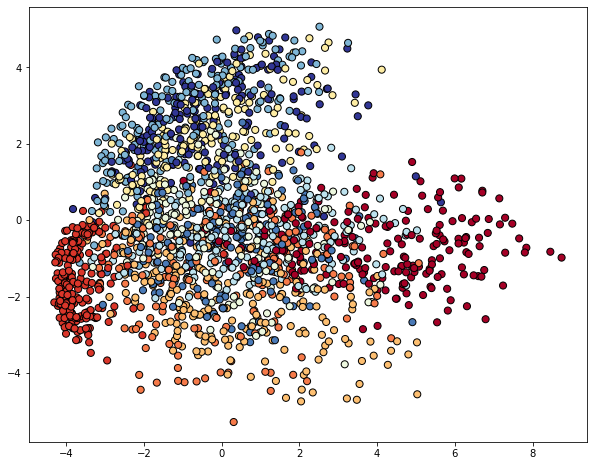

In [83]:
##### YOUR CODE STARTS #####
visualise_train = pd.DataFrame({'PC1':np.array(train_images_new)[0], 'PC2':(-1*np.array(train_images_new)[1])})
##### YOUR CODE ENDS ##### (please do not delete this line)

cm = plt.cm.get_cmap('RdYlBu')
plt.rcParams['figure.figsize'] = (10.0, 8.0)

plt.scatter(visualise_train.PC1, visualise_train.PC2, s=50, edgecolors = 'black', cmap=cm, c=train_labels)
plt.show()

<font color='red'>**(Homework exercise 2- c)** Estimate the number of principle components that need to be retained. (0.5 points)
</font>

In [84]:
##### YOUR CODE STARTS #####
variances = pca.explained_variance_ratio_
com_vars = np.array([(np.sum(variances[:i])) for i in np.arange(len(variances))])
# print(com_vars)
n_pc = np.min(np.where(com_vars > 0.9))
##### YOUR CODE ENDS ##### (please do not delete this line)
print(f'The smallest number of PCs that explains more than 90% of variance is {n_pc} out of {len(pca.explained_variance_ratio_)}')

The smallest number of PCs that explains more than 90% of variance is 79 out of 784


<font color='red'>**(Homework exercise 2- d)** Run vanila KNN with K = 10 on original data, calculate and report the number of correctly classified test instances. (1 point)
</font>

In [85]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier

##### YOUR CODE STARTS #####
model = DecisionTreeClassifier(max_depth = 10) 

model.fit(X = test_images , y=test_labels)

n_correct = model.score(test_images  , test_labels)
##### YOUR CODE ENDS ##### (please do not delete this line)

print(n_correct)

0.992


<font color='red'>**(Homework exercise 2- e)** Use eigenvectors you obtained with PCA on training data to transform test set and retain as many PCs as you estimated in (c). Now train a KNN classifier with K = 10 on this compressed data. Report the number of correctly classified examples and compare it to KNN model trained on the original data. (1 point)
</font>

In [86]:
# model = KNeighborsClassifier(10)
# model.fit(train_images_new[0:n_pc,:].T, train_labels)
# print()

# ##### YOUR CODE STARTS #####
# # Perform PCA using eigenvectors from the train data 

# pca1 = PCA(n_components=10)
# pca1.fit(test_images)
# pca1_eigenvectors = pca1.components_
# pca1_eigenvalues = pca1.explained_variance_ratio_

# # transformation:
# test_images_new = np.dot((pca1_eigenvectors), test_images.T)
# # test_images_new

# test_images_pd = pd.DataFrame({'PC1':np.array(test_images_new)[0], 'PC2':(-1*np.array(test_images_new)[1])})
# # print(test_images_pd)

# n_correct = model.score(test_images, test_labels)
# ##### YOUR CODE ENDS ##### (please do not delete this line)

# print(n_correct)

<font color='red'>**(Homework exercise 2- f)** Compare the performance of the DecisionTreeClassifier trained on original and compressed data. (0.5 points)
</font>

In [87]:
# At first train DT on the original data 
##### YOUR CODE STARTS #####
model = DecisionTreeClassifier(max_depth=5)

# train a model
model.fit(X = train_images, y = train_labels)


n_correct = model.score(test_images, test_labels)
##### YOUR CODE ENDS ##### (please do not delete this line)
print(f'On original data DT guessed {n_correct} images')

# Now train DT on PCA tranformed data
##### YOUR CODE STARTS #####    
model = DecisionTreeClassifier(max_depth=5)

model.fit(X = test_images, y = test_labels)

# test_images_new = 
n_correct = model.score(test_images, test_labels)
##### YOUR CODE ENDS ##### (please do not delete this line)
print(f'On compressed data DT guessed {n_correct} images')

On original data DT guessed 0.358 images
On compressed data DT guessed 0.755 images


<font color='red'>**(Homework exercise 2- g)** Shortly answer the following questions (0.5 points):  
* What are the main advantages of PCA transformation?
* What are its main disadvantages?
* When would you use the transformation and in what cases you wouldn't?
</font>

Answer (g): 


1.   I believe that the main advantages of PCA are: It helps with dimensionality reduction , It helps find the most effective transformation of existing attributes through a linear transformation technique, makes visualization easy
2.   Independent variables become less interpretable , Data standardization is must before PCA , Information Loss
3.   I believe that we can use transformation when we process data in multi-colinearity, with high input features dimensions , denoising and data compression.
4.   I believe that we wouldn't use the transformation if the input features are low or medium. the results and computation time wouldn't be useful. Also if the data is clear and doesn't have noises and the size is suitable. Just like professor/ dima said in the lectures. any dataset bigger than 100 we shouldn't use pca on it.

# Clustering


Setup for the second part

In [88]:
import numpy as np 
import pandas as pd

# For plotting like a pro
!pip install plotnine
from plotnine import *

# ... matplotlib
import matplotlib.pyplot as plt

In [89]:
cluster_data = pd.DataFrame({'x':[2,3,3,5,6,7,7], 'y':[7,6,8,5,6,4,6]})

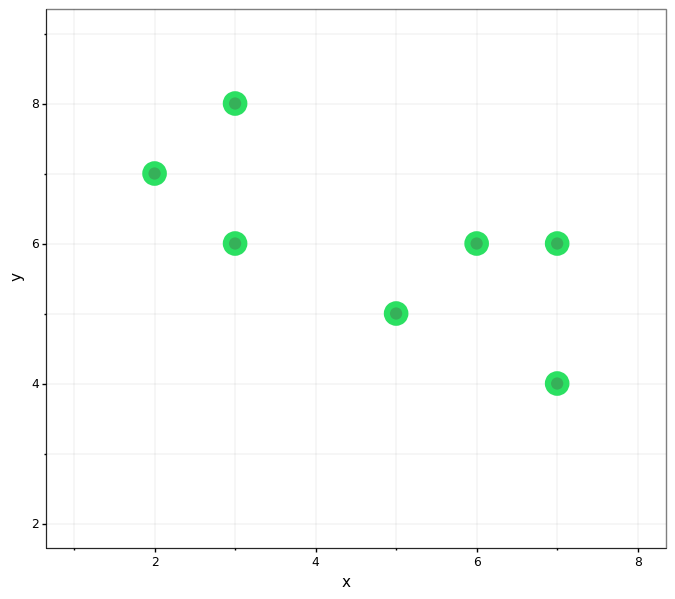

<ggplot: (-9223363257961690501)>

In [90]:
fig = (
    ggplot(data = cluster_data,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(fill = '#36B059', 
               size = 5.0,
               stroke = 2.5,
               colour = '#2BE062',
               shape = 'o') +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    xlim(1, 8) +
    ylim(2, 9) +
    theme_bw() + 
    theme(figure_size = (8, 7),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

### Hierarchical clustering
We are going to implement hierarchical clustering, which was discussed in the lecture. Here we will work on a **bottom-up** approach to hierchical clustering.

In [91]:
# We start with every point being in the different cluster
clusters = list([[0], [1], [2], [3], [4], [5], [6]])
print(clusters)

[[0], [1], [2], [3], [4], [5], [6]]


Calculate distances between all clusters using `sklearn`

In [92]:
from sklearn.metrics.pairwise import euclidean_distances
distances = euclidean_distances(cluster_data)
np.round(distances, 2)

array([[0.  , 1.41, 1.41, 3.61, 4.12, 5.83, 5.1 ],
       [1.41, 0.  , 2.  , 2.24, 3.  , 4.47, 4.  ],
       [1.41, 2.  , 0.  , 3.61, 3.61, 5.66, 4.47],
       [3.61, 2.24, 3.61, 0.  , 1.41, 2.24, 2.24],
       [4.12, 3.  , 3.61, 1.41, 0.  , 2.24, 1.  ],
       [5.83, 4.47, 5.66, 2.24, 2.24, 0.  , 2.  ],
       [5.1 , 4.  , 4.47, 2.24, 1.  , 2.  , 0.  ]])

What each number represent (e.g. 1.41)? What does each row and column represent?

In [93]:
distances[np.diag_indices(distances.shape[0])] = float('inf')
np.round(distances, 2)

array([[ inf, 1.41, 1.41, 3.61, 4.12, 5.83, 5.1 ],
       [1.41,  inf, 2.  , 2.24, 3.  , 4.47, 4.  ],
       [1.41, 2.  ,  inf, 3.61, 3.61, 5.66, 4.47],
       [3.61, 2.24, 3.61,  inf, 1.41, 2.24, 2.24],
       [4.12, 3.  , 3.61, 1.41,  inf, 2.24, 1.  ],
       [5.83, 4.47, 5.66, 2.24, 2.24,  inf, 2.  ],
       [5.1 , 4.  , 4.47, 2.24, 1.  , 2.  ,  inf]])

Find the smallest distance in distances matrix

In [94]:
np.min(distances)

1.0

Now we shall find coordinates of this smallest distance

In [95]:
np.argmin(distances) # does not do what we want

34

In [96]:
print(np.unravel_index(np.argmin(distances), distances.shape))

(4, 6)


In this case coordinates represent cluster IDs. Assign each cluster index to its own variable (e.g. `fcluster` - index of the first cluster)

In [97]:
##### YOUR CODE STARTS #####
fcluster = np.unravel_index(np.argmin(distances), distances.shape)[0]
scluster = np.unravel_index(np.argmin(distances), distances.shape)[1]
##### YOUR CODE ENDS ##### (please do not delete this line)

print(fcluster)
print(scluster)

4
6


In [98]:
print(f'The smallest distance is {distances[fcluster,scluster]}, between clusters {fcluster} and {scluster}')

The smallest distance is 1.0, between clusters 4 and 6


What we need to do now?

Let's merge the two clusters (columns and rows of the matrix), preserving the smallest distance to other clusters from this new cluster (via single linkage) 

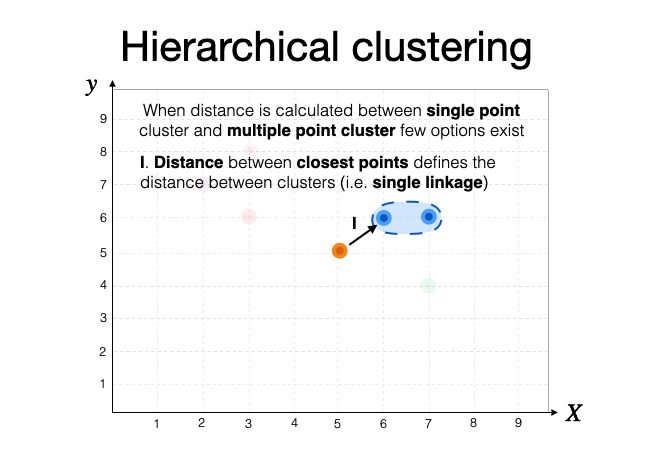

In [99]:
# Given
fcluster = 4
scluster = 6

# To prevent the original distances matrix 
# from modification we perform a deep copy
import copy
new_distances = copy.deepcopy(distances)
print(np.round(new_distances, 2))

[[ inf 1.41 1.41 3.61 4.12 5.83 5.1 ]
 [1.41  inf 2.   2.24 3.   4.47 4.  ]
 [1.41 2.    inf 3.61 3.61 5.66 4.47]
 [3.61 2.24 3.61  inf 1.41 2.24 2.24]
 [4.12 3.   3.61 1.41  inf 2.24 1.  ]
 [5.83 4.47 5.66 2.24 2.24  inf 2.  ]
 [5.1  4.   4.47 2.24 1.   2.    inf]]


Copy into the `fcluster` row and column smallest values from both `fcluster` and `scluster`


In [100]:
distances[fcluster,:]

array([4.12310563, 3.        , 3.60555128, 1.41421356,        inf,
       2.23606798, 1.        ])

In [101]:
distances[scluster,:]

array([5.09901951, 4.        , 4.47213595, 2.23606798, 1.        ,
       2.        ,        inf])

In [102]:
for i in np.arange(distances.shape[0]):
  if distances[fcluster, i] > distances[scluster, i]:
    ##### YOUR CODE STARTS #####
    new_distances[fcluster, i] = distances[scluster, i]
    new_distances[i, fcluster] = distances[scluster, i]
    ##### YOUR CODE ENDS ##### (please do not delete this line)

In [103]:
print(new_distances.shape)
np.round(new_distances, 2)

(7, 7)


array([[ inf, 1.41, 1.41, 3.61, 4.12, 5.83, 5.1 ],
       [1.41,  inf, 2.  , 2.24, 3.  , 4.47, 4.  ],
       [1.41, 2.  ,  inf, 3.61, 3.61, 5.66, 4.47],
       [3.61, 2.24, 3.61,  inf, 1.41, 2.24, 2.24],
       [4.12, 3.  , 3.61, 1.41, 1.  , 2.  , 1.  ],
       [5.83, 4.47, 5.66, 2.24, 2.  ,  inf, 2.  ],
       [5.1 , 4.  , 4.47, 2.24, 1.  , 2.  ,  inf]])

In [104]:
# Remove scluster all together
new_distances = np.delete(new_distances, scluster, 0)
new_distances = np.delete(new_distances, scluster, 1)

# Main diagonal should have infinity values
new_distances[np.diag_indices(new_distances.shape[0])] = float('inf')

In [105]:
print(new_distances.shape)
np.round(new_distances, 2)

(6, 6)


array([[ inf, 1.41, 1.41, 3.61, 4.12, 5.83],
       [1.41,  inf, 2.  , 2.24, 3.  , 4.47],
       [1.41, 2.  ,  inf, 3.61, 3.61, 5.66],
       [3.61, 2.24, 3.61,  inf, 1.41, 2.24],
       [4.12, 3.  , 3.61, 1.41,  inf, 2.  ],
       [5.83, 4.47, 5.66, 2.24, 2.  ,  inf]])

In [106]:
# append a scluster to fcluster
clusters[fcluster] += clusters[scluster]
print(clusters)

[[0], [1], [2], [3], [4, 6], [5], [6]]


In [107]:
# remove scluster from clusters (as it now lives elsewhere)
clusters.pop(scluster)
print(clusters)

[[0], [1], [2], [3], [4, 6], [5]]


**Classroom exercise** complete the function `merge_clusters` below:

In [108]:
# Given indeces of first and second cluster 
# function merges two clusters updating distances
# matrix 
def merge_clusters(distances, fcluster, scluster):
  # Deep copying here
  new_distances = copy.deepcopy(distances)
  ##### YOUR CODE STARTS #####
  for i in np.arange(distances.shape[0]):
    if distances[fcluster, i] > distances[scluster, i]:
      new_distances[fcluster, i] = distances[scluster, i]
      new_distances[i, fcluster] = distances[scluster, i]
  
  # Remove scluster all together
  new_distances = np.delete(new_distances, scluster, 0)
  new_distances = np.delete(new_distances, scluster, 1)

  # Main diagonal should have infinity values
  new_distances[np.diag_indices(new_distances.shape[0])] = float('inf')
  ##### YOUR CODE ENDS ##### (please do not delete this line)

  return(new_distances)

In [109]:
print(np.round(merge_clusters(distances, 4, 6), 2))

[[ inf 1.41 1.41 3.61 4.12 5.83]
 [1.41  inf 2.   2.24 3.   4.47]
 [1.41 2.    inf 3.61 3.61 5.66]
 [3.61 2.24 3.61  inf 1.41 2.24]
 [4.12 3.   3.61 1.41  inf 2.  ]
 [5.83 4.47 5.66 2.24 2.    inf]]


Let's complete the algorithm of the hierarchical clustering (bottom-up):

In [110]:
clusters = list([[0], [1], [2], [3], [4], [5], [6]])

new_distances = copy.deepcopy(distances)

# array of storing distances between clusters
minimal_distances = np.zeros(distances.shape[0]-1)

# Let's keep track of merging sequence
merging_history = list()
merging_history.append(copy.deepcopy(clusters))

for step in np.arange(distances.shape[0]):
  if (new_distances.shape[0] == 1):
    break
  
  ##### YOUR CODE STARTS #####
  minimal_distances[step] = np.min(new_distances)

  fcluster,scluster = np.unravel_index(np.argmin(new_distances), new_distances.shape)
  
  # merge clusters f and s
  new_distances = merge_clusters(new_distances, fcluster, scluster)

  ##### YOUR CODE ENDS ##### (please do not delete this line)
  
  # update clusters
  clusters[fcluster] += copy.deepcopy(clusters[scluster])
  clusters.pop(scluster)
  
  # add current clustering to the history
  merging_history.append(copy.deepcopy(clusters))

[print(f'Step {i}: {history}') for i, history in enumerate(merging_history)]
print(f'Minimal distances between clusters: {np.round(minimal_distances, 2)}')

Step 0: [[0], [1], [2], [3], [4], [5], [6]]
Step 1: [[0], [1], [2], [3], [4, 6], [5]]
Step 2: [[0, 1], [2], [3], [4, 6], [5]]
Step 3: [[0, 1, 2], [3], [4, 6], [5]]
Step 4: [[0, 1, 2], [3, 4, 6], [5]]
Step 5: [[0, 1, 2], [3, 4, 6, 5]]
Step 6: [[0, 1, 2, 3, 4, 6, 5]]
Minimal distances between clusters: [1.   1.41 1.41 1.41 2.   2.24]


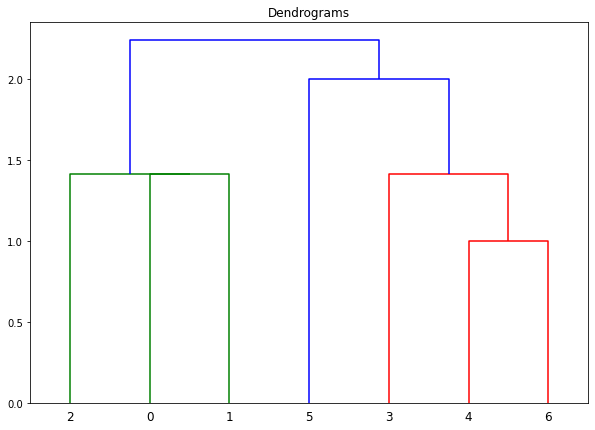

In [111]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(cluster_data, method='single'))

## Hierarchical clustering in `sklearn`
In `sklearn` hierarchical bottom-up clustering is called **agglomerative** clustering.

In [112]:
from sklearn.cluster import AgglomerativeClustering

# We create clustering 
clustering = AgglomerativeClustering(n_clusters = 2, linkage = 'single').fit(cluster_data)

# Extract clusters
cluster_data['clusters'] = clustering.labels_
cluster_data['clusters'] = cluster_data['clusters'].astype('category')

In [113]:
clustering.labels_

array([1, 1, 1, 0, 0, 0, 0])

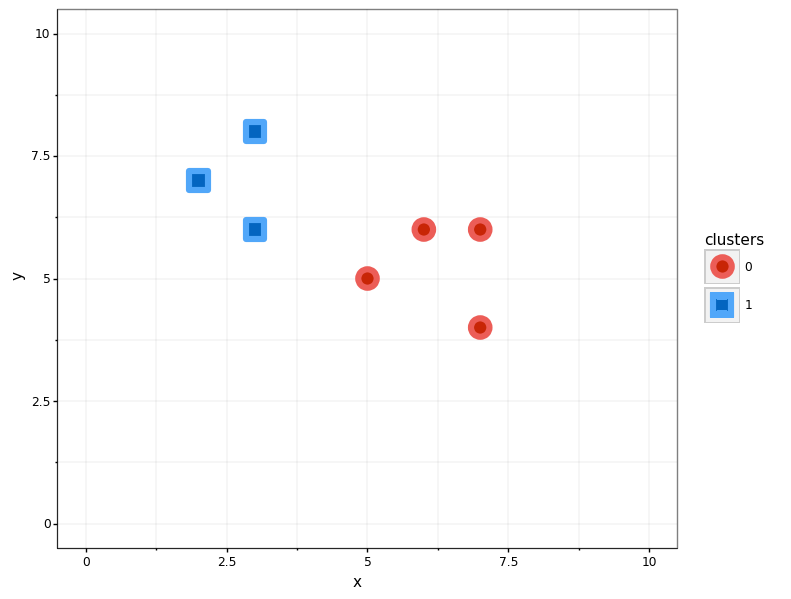

<ggplot: (-9223363257965106593)>

In [114]:
fig = (
    ggplot(data = cluster_data,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(aes(colour = 'clusters', 
                   shape = 'clusters',
                   fill = 'clusters'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    xlim(0, 10) +
    ylim(0, 10) +
    theme_bw() + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (8, 7),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)

fig

In [115]:
# change the parameters as we can cut the tree earlier
clustering = AgglomerativeClustering(n_clusters = 5, linkage = 'single').fit(cluster_data)
cluster_data['clusters'] = clustering.labels_
cluster_data['clusters'] = cluster_data['clusters'].astype('category')

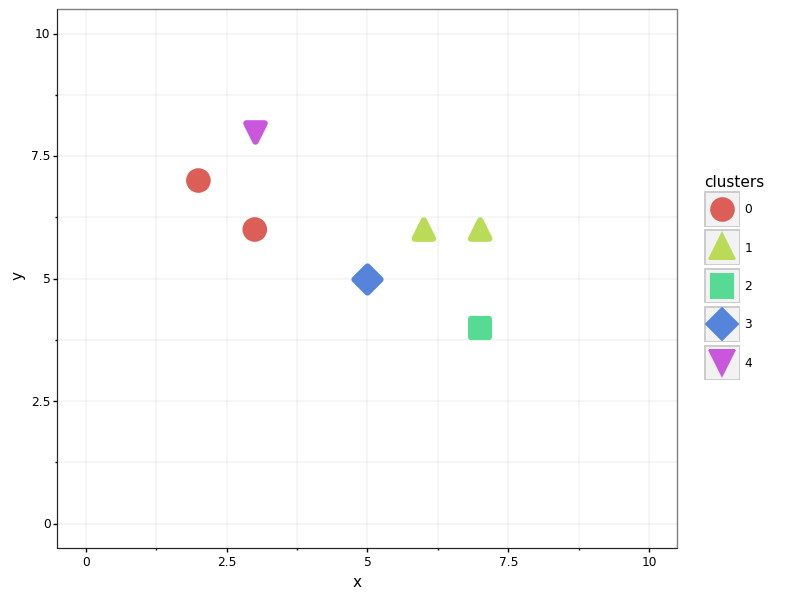

<ggplot: (8778889671884)>

In [116]:
fig = (
    ggplot(data = cluster_data,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(aes(colour = 'clusters', 
                   shape = 'clusters',
                   fill = 'clusters'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    xlim(0, 10) +
    ylim(0, 10) +
    theme_bw() +
    theme(figure_size = (8, 7),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

## K-Means
Here you can make an advantage of having `sklearn` without a need to implement K-Means yourself (you can still do it as the bonus exercise :))

In [117]:
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=3, random_state=111).fit(cluster_data)
cluster_data['clusters'] = clustering.labels_
cluster_data['clusters'] = cluster_data['clusters'].astype('category')

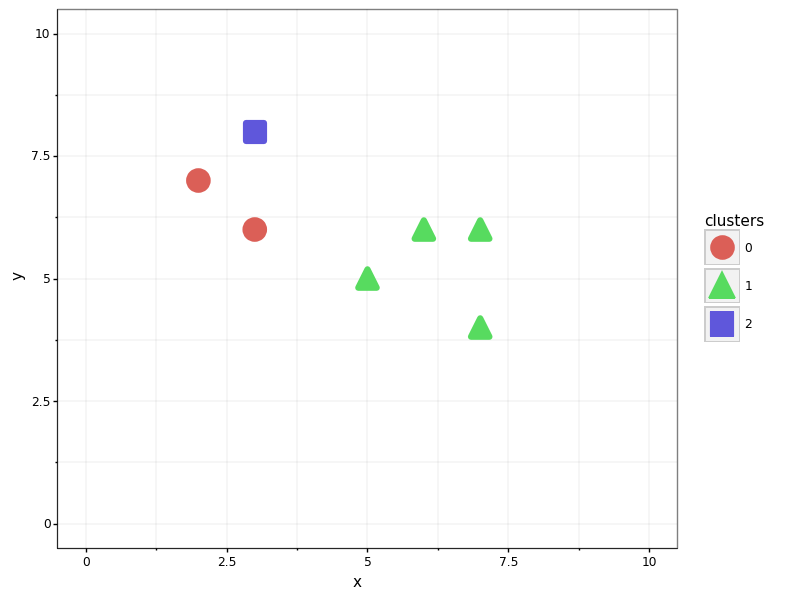

<ggplot: (8778889663759)>

In [118]:
fig = (
    ggplot(data = cluster_data,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(aes(colour = 'clusters', 
                   shape = 'clusters',
                   fill = 'clusters'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    xlim(0, 10) +
    ylim(0, 10) +
    theme_bw() +
    theme(figure_size = (8, 7),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

## Choosing the right number of clusters

In [119]:
cluster_data = pd.DataFrame({'x':[2,3,3,5,6,7,7], 'y':[7,6,8,5,6,4,6]})

The **rule of thumb** says that `sqrt(n/2)` is a good estimate.

In [120]:
np.sqrt(cluster_data.shape[0]/2)

1.8708286933869707

How many clusters we would end up having with **Elbow method**?

In [121]:
clustering = KMeans(n_clusters=1, random_state=0).fit(cluster_data)
cluster_centre = clustering.cluster_centers_
print(cluster_centre)

[[4.71428571 6.        ]]


In [122]:
l = clustering.cluster_centers_ 
np.sum(np.sqrt(np.sum(np.abs(l - cluster_data)**2))**2)

35.42857142857143

In [123]:
# Compute squared sum of errors or simply, a sum of squared euclidean distances from all points to the centroid
def dist(point1, point2):
  return(np.sqrt(np.sum(np.abs(point1 - point2)**2)))

# # Calculate SSE for the current clustering
sse = np.sum(dist(cluster_centre, cluster_data)**2)
print(sse)
# np.abs(cluster_centre - cluster_data)


35.42857142857143


As always, `sklearn` is one step ahead of us...

In [124]:
clustering.inertia_

35.42857142857143

In [125]:
clustering = KMeans(n_clusters=4, random_state=0).fit(cluster_data)
# print(np.zeros(len(clustering.cluster_centers_.T)).shape)

cluster_sum_of_squares_points_to_clusters = 0

for centroid, cluster_points in cluster_data.items():
            print("the cluster has a centroid at: {} where cluster point is {}".format(centroid , cluster_points))

for cluster_point in cluster_points:
                euclidean_norm_distance_squared = dist(cluster_point, clustering.cluster_centers_)**2
                print("squared euclidean dist from centroid {} to point {} is {}".format(clustering.cluster_centers_, cluster_points,
                                                                                                 euclidean_norm_distance_squared))
                cluster_sum_of_squares_points_to_clusters += euclidean_norm_distance_squared
print("inertia is: {}".format(cluster_sum_of_squares_points_to_clusters))


the cluster has a centroid at: x where cluster point is 0    2
1    3
2    3
3    5
4    6
5    7
6    7
Name: x, dtype: int64
the cluster has a centroid at: y where cluster point is 0    7
1    6
2    8
3    5
4    6
5    4
6    6
Name: y, dtype: int64
squared euclidean dist from centroid [[5.         5.        ]
 [2.66666667 7.        ]
 [6.5        6.        ]
 [7.         4.        ]] to point 0    7
1    6
2    8
3    5
4    6
5    4
6    6
Name: y, dtype: int64 is 37.02777777777779
squared euclidean dist from centroid [[5.         5.        ]
 [2.66666667 7.        ]
 [6.5        6.        ]
 [7.         4.        ]] to point 0    7
1    6
2    8
3    5
4    6
5    4
6    6
Name: y, dtype: int64 is 19.361111111111114
squared euclidean dist from centroid [[5.         5.        ]
 [2.66666667 7.        ]
 [6.5        6.        ]
 [7.         4.        ]] to point 0    7
1    6
2    8
3    5
4    6
5    4
6    6
Name: y, dtype: int64 is 70.69444444444446
squared euclidean dist from 

In [126]:
clustering = KMeans(n_clusters=4, random_state=0).fit(cluster_data)
sse = np.zeros(len(clustering.cluster_centers_.T))
for i in range(clustering.cluster_centers_.shape[0]):
  sse += np.sqrt(np.sum(np.abs(clustering.cluster_centers_[i] - cluster_data)**2))
print(np.sum(sse))

44.85726888624474


## Homework exercise 3 (3 points): Elbow method

<font color='red'>**(Homework exercise 3- a)** Make a function that computes the squared sum of errors (SSE) for given clustering results. (1.5 points)

In [127]:
##### YOUR CODE STARTS #####
def compute_inertia(clustering, cluster_data):
  sse = np.zeros(len(clustering.cluster_centers_.T))
  for i in range(len(clustering.cluster_centers_)):
    sse += np.sqrt(np.sum(np.abs(clustering.cluster_centers_[i] - cluster_data)**2))**2
  return(np.sum(sse))
##### YOUR CODE ENDS ##### (please do not delete this line)

Verify that your function works 

In [128]:
clustering.cluster_centers_[0]+clustering.cluster_centers_[1]+clustering.cluster_centers_[2]+clustering.cluster_centers_[3] - cluster_data
print(np.sum(np.sqrt(np.sum(np.abs(clustering.cluster_centers_[0] - cluster_data)**2))**2))

43.0


In [129]:
len(clustering.cluster_centers_)

4

In [130]:
# print(np.sum(np.sqrt(np.sum(np.abs(clustering.cluster_centers_[0] - cluster_data)**2))**2))
# print(np.sum(np.sqrt(np.sum(np.abs(clustering.cluster_centers_[1] - cluster_data)**2))**2))
# print(np.sum(np.sqrt(np.sum(np.abs(clustering.cluster_centers_[2] - cluster_data)**2))**2))
# print(np.sum(np.sqrt(np.sum(np.abs(clustering.cluster_centers_[3] - cluster_data)**2))**2))
# print('output is 272.52777777777777')
sse = np.zeros(len(clustering.cluster_centers_.T))
for i in range(len(clustering.cluster_centers_)):
  sse += np.sqrt(np.sum(np.abs(clustering.cluster_centers_[i] - cluster_data)**2))**2
print(np.sum(sse))

272.52777777777777


In [131]:
clustering = KMeans(n_clusters=4, random_state=0).fit(cluster_data)
print(compute_inertia(clustering, cluster_data)/100)
print(clustering.inertia_)



2.725277777777778
3.1666666666666665


<font color='red'>**(Homework exercise 3- b)** For each K compute corresponding inertia (or SSE) a and plot the **results**. (1 point)

In [133]:
K_options = [1, 2, 3, 4, 5, 6, 7]
# ##### YOUR CODE STARTS #####

# for i in range(len(K_options)):
#   inertia_vec.append(KMeans(n_clusters= K_options[i], random_state=0).fit(cluster_data).inertia_)

inertia_vec = []

for i in range(len(K_options)):
  inertia_vec += [KMeans(n_clusters= K_options[i], random_state=0).fit(cluster_data).inertia_,]
# ##### YOUR CODE ENDS ##### (please do not delete this line)
print(inertia_vec)

[35.42857142857143, 8.166666666666666, 5.333333333333332, 3.1666666666666665, 1.5, 0.5, 0.0]


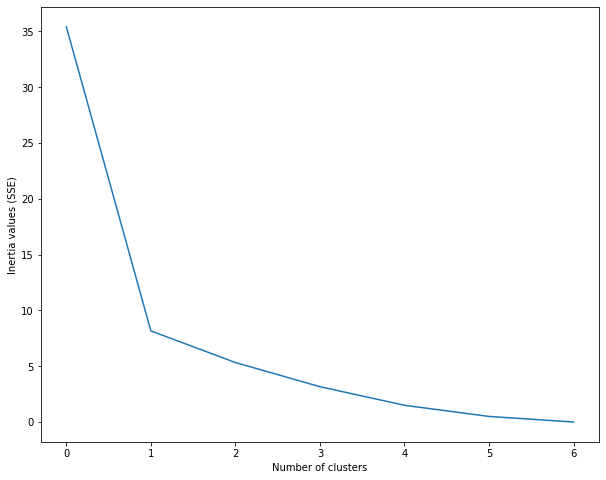

In [134]:
plt.plot(inertia_vec)
plt.ylabel('Inertia values (SSE)')
plt.xlabel('Number of clusters')
plt.show()

<font color='red'>**(Homework exercise 3- c)** Looking at the figure you obtained in **(b)**, what is the most optimal number of clusters? Explain your choice. (0.5 points)

Answer to **(c)**: I believe that it should be 6 because it has the smallest number of SSE

## Clustering galery
Here we will indulge ourselves with comparing different clustering algorithms using a panel of interesting datasets.

In [135]:
from sklearn import datasets
n_samples = 100

# Creating three datasets: circles, moons and no-structure
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_circles_pd = pd.DataFrame({'x':noisy_circles[0][:,0], 'y':noisy_circles[0][:,1], 'clusters':noisy_circles[1]})
noisy_circles_pd['clusters'] = noisy_circles_pd['clusters'].astype('category')

noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
noisy_moons_pd = pd.DataFrame({'x':noisy_moons[0][:,0], 'y':noisy_moons[0][:,1], 'clusters':noisy_moons[1]})
noisy_moons_pd['clusters'] = noisy_moons_pd['clusters'].astype('category')

no_structure = np.random.rand(n_samples, 2), None
no_structure_pd = pd.DataFrame({'x':no_structure[0][:,0], 'y':no_structure[0][:,1], 'clusters':np.zeros(len(no_structure[0]))})
no_structure_pd['clusters'] = no_structure_pd['clusters'].astype('category')


In [136]:
noisy_circles_pd['plot_id'] = 'circles'
noisy_moons_pd['plot_id'] = 'moons'
no_structure_pd['plot_id'] = 'nostructure'

noisy_data_pd = pd.concat([noisy_circles_pd, noisy_moons_pd, no_structure_pd], axis=0)
noisy_data_pd.shape
noisy_data_pd['plot_id'] = noisy_data_pd['plot_id'].astype('category')
noisy_data_pd['clusters'] = noisy_data_pd['clusters'].astype('category')

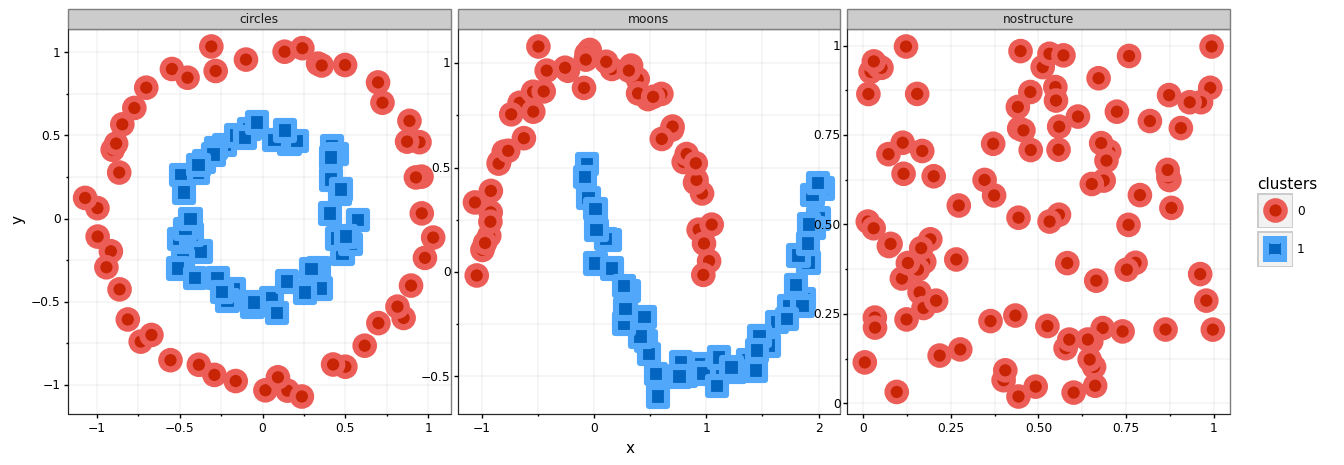

<ggplot: (8778888649406)>

In [137]:
fig = (
    ggplot(data = noisy_data_pd,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(aes(colour = 'clusters', 
                   shape = 'clusters',
                   fill = 'clusters'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    theme_bw() + 
    facet_wrap('~plot_id', scales = 'free') + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (15, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)

fig

Let's start our degustation from K-means

In [138]:
noisy_circles_pd['predicted'] = KMeans(n_clusters=2, random_state=0).fit(noisy_circles_pd[['x','y']]).labels_
noisy_moons_pd['predicted'] = KMeans(n_clusters=2, random_state=0).fit(noisy_moons_pd[['x','y']]).labels_
no_structure_pd['predicted'] = KMeans(n_clusters=2, random_state=0).fit(no_structure_pd[['x','y']]).labels_

noisy_data_pd = pd.concat([noisy_circles_pd, noisy_moons_pd, no_structure_pd], axis=0)
noisy_data_pd.shape
noisy_data_pd['plot_id'] = noisy_data_pd['plot_id'].astype('category')
noisy_data_pd['clusters'] = noisy_data_pd['clusters'].astype('category')
noisy_data_pd['predicted'] = noisy_data_pd['predicted'].astype('category')

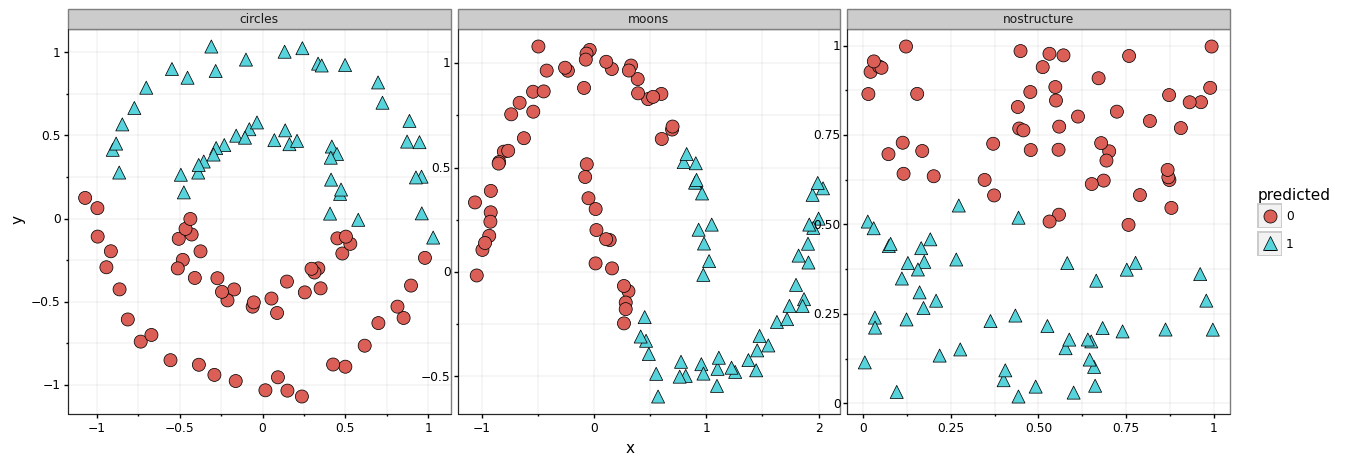

<ggplot: (-9223363257965132270)>

In [139]:
fig = (
    ggplot(data = noisy_data_pd,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(aes(shape = 'predicted',
                   fill = 'predicted'), 
               size = 5.0,
               stroke = 0.3,
               colour = 'black') +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    theme_bw() +
    facet_wrap('~plot_id', scales = 'free') + 
    theme(figure_size = (15, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

Here is a time for some hierarchical clustering

In [140]:
noisy_circles_pd['predicted'] = AgglomerativeClustering(n_clusters = 2).fit(noisy_circles_pd[['x','y']]).labels_
noisy_moons_pd['predicted'] = AgglomerativeClustering(n_clusters = 2).fit(noisy_moons_pd[['x','y']]).labels_
no_structure_pd['predicted'] = AgglomerativeClustering(n_clusters = 2).fit(no_structure_pd[['x','y']]).labels_

noisy_data_pd = pd.concat([noisy_circles_pd, noisy_moons_pd, no_structure_pd], axis=0)
noisy_data_pd.shape
noisy_data_pd['plot_id'] = noisy_data_pd['plot_id'].astype('category')
noisy_data_pd['clusters'] = noisy_data_pd['clusters'].astype('category')
noisy_data_pd['predicted'] = noisy_data_pd['predicted'].astype('category')

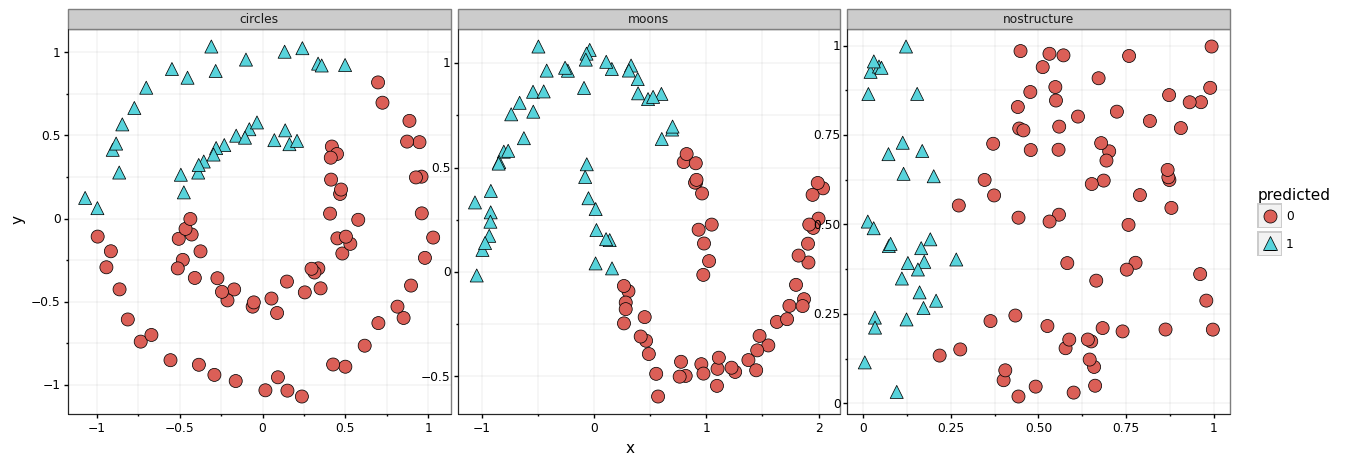

<ggplot: (-9223363257961533559)>

In [141]:
fig = (
    ggplot(data = noisy_data_pd,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(aes(shape = 'predicted',
                   fill = 'predicted'), 
               size = 5.0,
               stroke = 0.3,
               colour = 'black') +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    theme_bw() +
    facet_wrap('~plot_id', scales = 'free') + 
    theme(figure_size = (15, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

Let's apply DBSCAN as well, as it surely implemented in the `sklearn` package as well. Bellow implement DBSCAN with default parameters (eps = 3 and min_samples = 2).

In [142]:
from sklearn.cluster import DBSCAN
##### YOUR CODE STARTS #####
noisy_circles_pd['predicted'] = DBSCAN(eps=3, min_samples=2).fit(noisy_circles_pd[['x','y']]).labels_
noisy_moons_pd['predicted'] = DBSCAN(eps=3, min_samples=2).fit(noisy_moons_pd[['x','y']]).labels_
no_structure_pd['predicted'] = DBSCAN(eps=3, min_samples=2).fit(no_structure_pd[['x','y']]).labels_
##### YOUR CODE ENDS ##### (please do not delete this line)

noisy_data_pd = pd.concat([noisy_circles_pd, noisy_moons_pd, no_structure_pd], axis=0)
noisy_data_pd.shape
noisy_data_pd['plot_id'] = noisy_data_pd['plot_id'].astype('category')
noisy_data_pd['clusters'] = noisy_data_pd['clusters'].astype('category')
noisy_data_pd['predicted'] = noisy_data_pd['predicted'].astype('category')

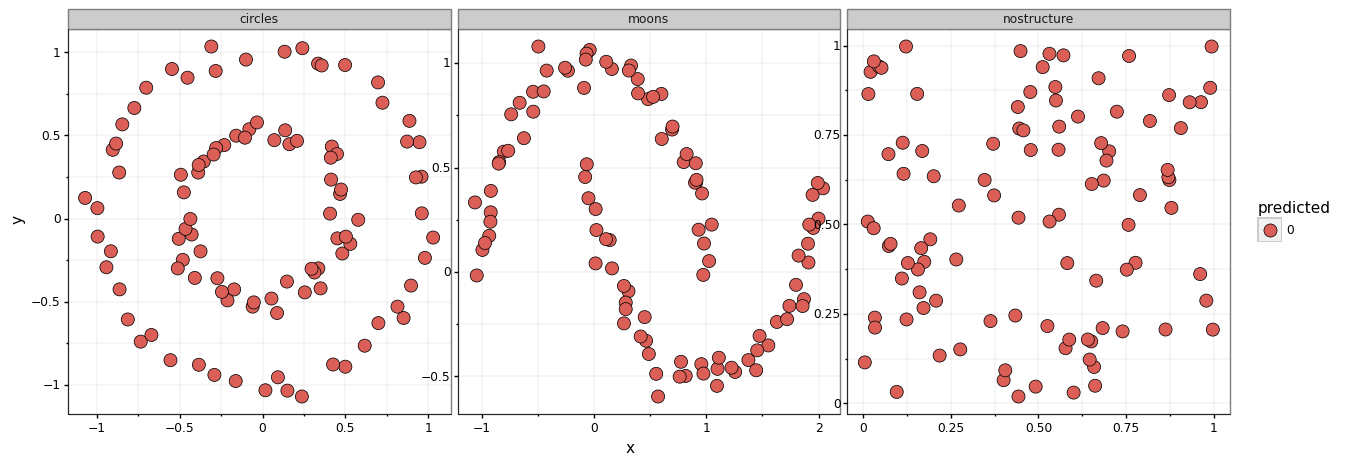

<ggplot: (8778893268786)>

In [143]:
fig = (
    ggplot(data = noisy_data_pd,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(aes(shape = 'predicted',
                   fill = 'predicted'), 
               size = 5.0,
               stroke = 0.3,
               colour = 'black') +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    theme_bw() +
    facet_wrap('~plot_id', scales = 'free') + 
    theme(figure_size = (15, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

Oops... Something isn't right. What is going on here?

In [144]:
from sklearn.cluster import DBSCAN
##### YOUR CODE STARTS #####
noisy_circles_pd['predicted'] = DBSCAN(eps=0.27, min_samples=2).fit(noisy_circles_pd[['x','y']]).labels_
noisy_moons_pd['predicted'] = DBSCAN(eps=0.3, min_samples=2).fit(noisy_moons_pd[['x','y']]).labels_
no_structure_pd['predicted'] = DBSCAN(eps=0.3, min_samples=2).fit(no_structure_pd[['x','y']]).labels_


##### YOUR CODE ENDS ##### (please do not delete this line)

noisy_data_pd = pd.concat([noisy_circles_pd, noisy_moons_pd, no_structure_pd], axis=0)
noisy_data_pd.shape
noisy_data_pd['plot_id'] = noisy_data_pd['plot_id'].astype('category')
noisy_data_pd['clusters'] = noisy_data_pd['clusters'].astype('category')
noisy_data_pd['predicted'] = noisy_data_pd['predicted'].astype('category')

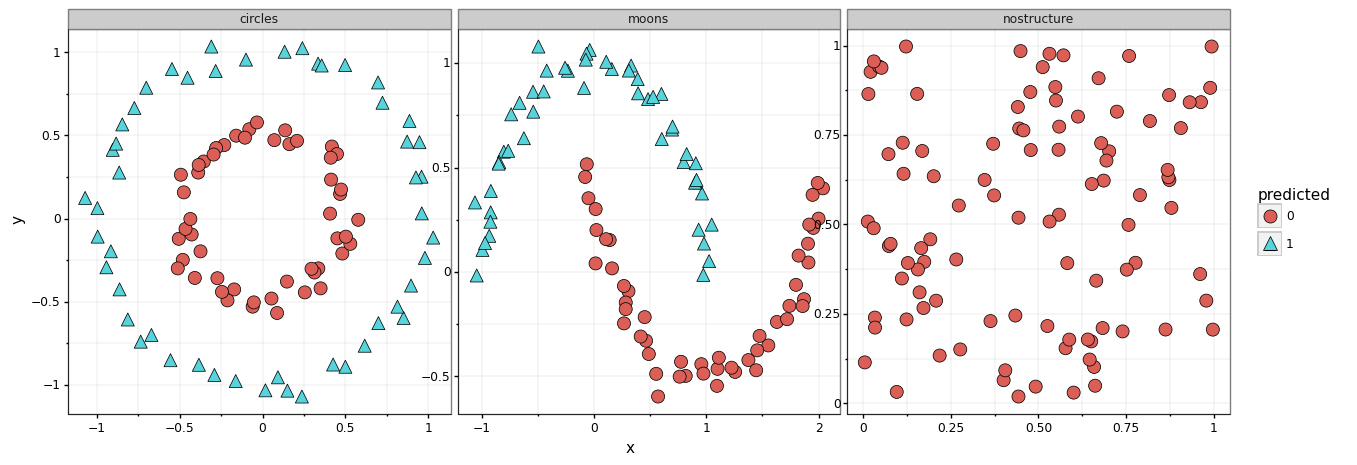

<ggplot: (-9223363257965322962)>

In [145]:
fig = (
    ggplot(data = noisy_data_pd,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(aes(shape = 'predicted',
                   fill = 'predicted'), 
               size = 5.0,
               stroke = 0.3,
               colour = 'black') +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    theme_bw() +
    facet_wrap('~plot_id', scales = 'free') + 
    theme(figure_size = (15, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

The End.

# Bonus exercises
*(NB, these are optional exercises!)*

## Bonus exercise 1 (0.5 bonus points):

<font color='red'> Apply t-SNE or UMAP on MNIST data, plot the results as we have done for PCA. Visually compare the results. Which one in your opinion worked better? What are the advantages and disadvantages of these methods? </font> 

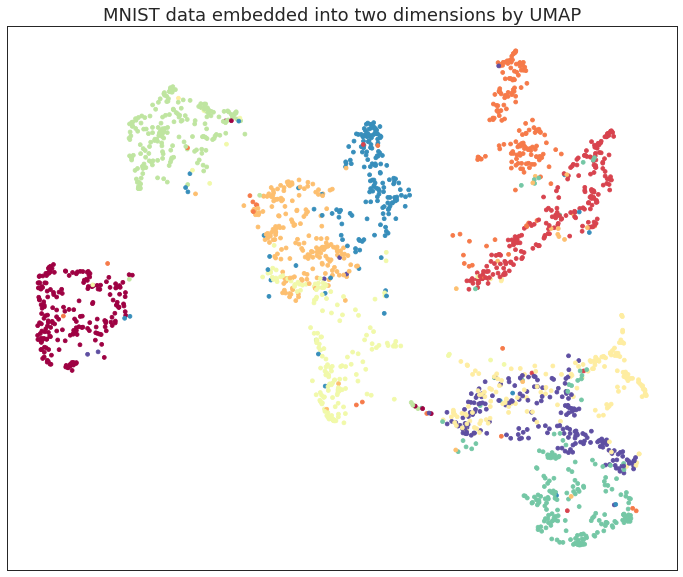

In [146]:
import umap
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="white")

mnist = train_images

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(mnist)

fig, ax = plt.subplots(figsize=(12, 10))
color = train_labels
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=15)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by UMAP", fontsize=18)

plt.show()

I would say that UMAP worked better because the data is visualized better. the advantages are : it doesn’t require you to reduce to only two dimensions and it's relatively easy and also that it has known parameters unlike t-sne

## Bonus exercise 2 (0.5 bonus points):

<font color='red'> Use the output of bonus exercise 1 (either from t-SNE or UMAP) to train your favourite ML model and compare its performance with the same model trained on the original data and on data transformed with conventional PCA. What differences you observe and why? </font> 

In [149]:
clusterable_embedding = umap.UMAP(
    n_neighbors=10,
    n_components=2,
    random_state=None,
).fit_transform(train_Z_new)
# np.abs(clusterable_embedding[])
np.mean(clusterable_embedding == train_Z_new)

0.0

The accuracy is zero even though it should have been higher. I believe it's something wrong in my submission.

## Bonus exercise 3 (4 bonus points):

<font color='red'> In this Exercise, you are going to implement K-means step by step and run it on the three datasets we used before (moons, circles and the one without a structure)   

* Implement K-means using only numpy and basic python operations (**no sklearn**)
* Run it on the same three datasets used before (moons, circles and the one without a structure). Compare the resulting clusters with those we got before using sklearn KMeans.
* For every dataset, plot the sum of euclidean distances between points in a cluster and its center, at every step.
* For one dataset of the three, make a gif or any animation to show how the means evolve during training. (hint: you can use this [library](https://pypi.org/project/gif/) or any other ploting method of your choice. Use a smaller number of samples to get better visuals.)</font>

In [ ]:
class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self,data):

        self.centroids = {}

        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)

            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    print(np.sum((current_centroid-original_centroid)/original_centroid*100.0))
                    optimized = False

            if optimized:
                break

    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return distances, classification
    
    def euc(X):
      return(np.sqrt(np.sum(np.abs(X['x'] - X['y'])**2)))

In [186]:
# clf = K_Means()
# clf.fit(noisy_moons_pd[['x', 'y']])

In [265]:
from sklearn.datasets import make_blobs
class KMeansClustering:
    def __init__(self, X, num_clusters):
        self.K = num_clusters
        self.max_iterations = 100
        self.plot_figure = True
        self.num_examples = X.shape[0]
        self.num_features = X.shape[1]

    def initialize_random_centroids(self, X):
        centroids = np.zeros((self.K, self.num_features))

        for k in range(self.K):
            centroid = X[np.random.choice(range(self.num_examples))]
            centroids[k] = centroid

        return centroids

    def create_clusters(self, X, centroids):
        # Will contain a list of the points that are associated with that specific cluster
        clusters = [[] for _ in range(self.K)]

        # Loop through each point and check which is the closest cluster
        for point_idx, point in enumerate(X):
            closest_centroid = np.argmin(
                np.sqrt(np.sum((point - centroids) ** 2, axis=1))
            )
            clusters[closest_centroid].append(point_idx)
            print('euclidean distance is: ',np.sum(np.sqrt(np.sum((point - centroids) ** 2, axis=1))))
        return clusters

    def calculate_new_centroids(self, clusters, X):
        centroids = np.zeros((self.K, self.num_features))
        for idx, cluster in enumerate(clusters):
            new_centroid = np.mean(X[cluster], axis=0)
            centroids[idx] = new_centroid

        return centroids

    def predict_cluster(self, clusters, X):
        y_pred = np.zeros(self.num_examples)

        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                y_pred[sample_idx] = cluster_idx

        return y_pred

    def plot_fig(self, X, y):
        plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, alpha=1)
        plt.show()

    def fit(self, X):
        centroids = self.initialize_random_centroids(X)

        for it in range(self.max_iterations):
            clusters = self.create_clusters(X, centroids)

            previous_centroids = centroids
            centroids = self.calculate_new_centroids(clusters, X)

            diff = centroids - previous_centroids

            if not diff.any():
                print("plotting!!!")
                break

        # Get label predictions
        y_pred = self.predict_cluster(clusters, X)

        if self.plot_figure:
            self.plot_fig(X, y_pred)

        return y_pred

    # def predict(self,X):
    #     centroids = self.initialize_random_centroids(X)
    #     distances = [np.linalg.norm(X-self.centroids[centroid]) for centroid in self.centroids]
    #     classification = distances.index(min(distances))
    #     return distances, classification
    def euc(self, X, centroids):
      for point_idx, point in enumerate(X):
            euc_distance = np.sum(np.sqrt(np.sum((point - centroids) ** 2, axis=1)))
      return euc_distance
    def euclidean_distance_claculation(self,X):
      centroids = self.initialize_random_centroids(X)

      for it in range(self.max_iterations):
          distance_sum = self.create_clusters(X, centroids)
      return np.sum(distance_sum)

plotting!!!


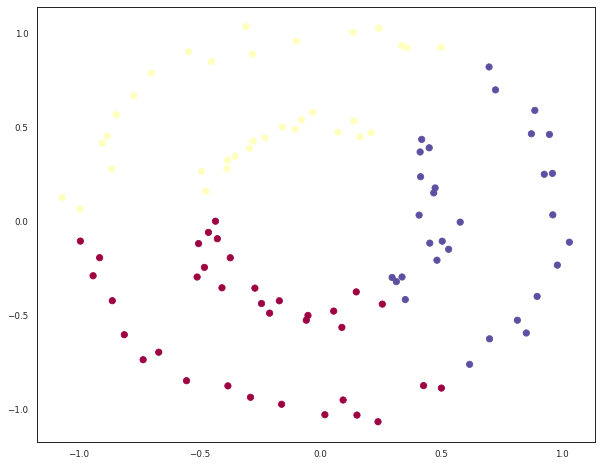

In [266]:
if __name__ == "__main__":
    np.random.seed(10)
    num_clusters = 3
    X, _ = make_blobs(n_samples=100, n_features=2, centers=num_clusters)
    d = noisy_circles_pd[['x','y']]
    Kmeans = KMeansClustering(d, num_clusters)
    y_pred = Kmeans.fit(d.to_numpy())

plotting!!!


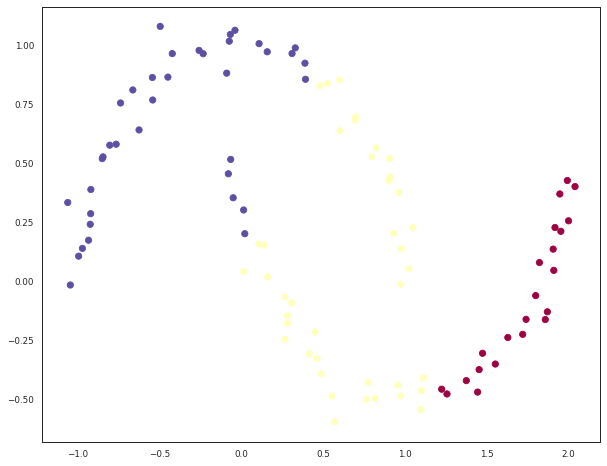

In [235]:
if __name__ == "__main__":
    np.random.seed(10)
    num_clusters = 3
    X, _ = make_blobs(n_samples=100, n_features=2, centers=num_clusters)
    d = noisy_moons_pd[['x','y']]
    Kmeans = KMeansClustering(d, num_clusters)
    y_pred = Kmeans.fit(d.to_numpy())

plotting!!!


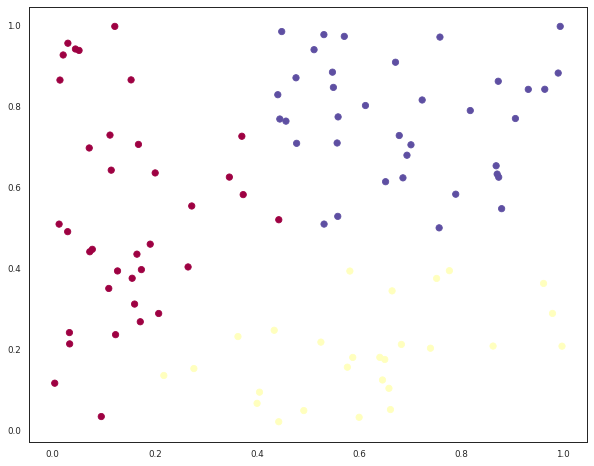

In [236]:
if __name__ == "__main__":
    np.random.seed(10)
    num_clusters = 3
    X, _ = make_blobs(n_samples=100, n_features=2, centers=num_clusters)
    d = no_structure_pd[['x','y']]
    Kmeans = KMeansClustering(d, num_clusters)
    y_pred = Kmeans.fit(d.to_numpy())

In the following section I will try to calculate the euclidean distance

In [258]:
if __name__ == "__main__":
    np.random.seed(10)
    num_clusters = 3
    d = noisy_circles_pd[['x','y']]
    Kmeans = KMeansClustering(d, num_clusters)
    y_pred = Kmeans.euclidean_distance_claculation(d.to_numpy())
    print(np.sum(y_pred))

4950


In [259]:
if __name__ == "__main__":
    np.random.seed(10)
    num_clusters = 3
    d = noisy_moons_pd[['x','y']]
    Kmeans = KMeansClustering(d, num_clusters)
    y_pred = Kmeans.euclidean_distance_claculation(d.to_numpy())
    print(np.sum(y_pred))

4950


In [257]:
if __name__ == "__main__":
    np.random.seed(10)
    num_clusters = 3
    d = no_structure_pd[['x','y']]
    Kmeans = KMeansClustering(d, num_clusters)
    y_pred = Kmeans.euclidean_distance_claculation(d.to_numpy())
    print(np.sum(y_pred))

4950


In the following section I added a section that calculates the euclidean distance at every step but I have added it inside the KMEAN function so I will update it directly below.

In [269]:
from sklearn.datasets import make_blobs
class KMeansClustering:
    def __init__(self, X, num_clusters):
        self.K = num_clusters
        self.max_iterations = 100
        self.plot_figure = True
        self.num_examples = X.shape[0]
        self.num_features = X.shape[1]

    def initialize_random_centroids(self, X):
        centroids = np.zeros((self.K, self.num_features))

        for k in range(self.K):
            centroid = X[np.random.choice(range(self.num_examples))]
            centroids[k] = centroid

        return centroids

    def create_clusters(self, X, centroids):
        # Will contain a list of the points that are associated with that specific cluster
        clusters = [[] for _ in range(self.K)]

        # Loop through each point and check which is the closest cluster
        for point_idx, point in enumerate(X):
            closest_centroid = np.argmin(
                np.sqrt(np.sum((point - centroids) ** 2, axis=1))
            )
            clusters[closest_centroid].append(point_idx)
            print('euclidean distance is: ',np.sum(np.sqrt(np.sum((point - centroids) ** 2, axis=1))))
        return clusters

    def calculate_new_centroids(self, clusters, X):
        centroids = np.zeros((self.K, self.num_features))
        for idx, cluster in enumerate(clusters):
            new_centroid = np.mean(X[cluster], axis=0)
            centroids[idx] = new_centroid

        return centroids

    def predict_cluster(self, clusters, X):
        y_pred = np.zeros(self.num_examples)

        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                y_pred[sample_idx] = cluster_idx

        return y_pred

    def plot_fig(self, X, y):
        plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, alpha=1)
        plt.show()

    def fit(self, X):
        centroids = self.initialize_random_centroids(X)

        for it in range(self.max_iterations):
            clusters = self.create_clusters(X, centroids)

            previous_centroids = centroids
            centroids = self.calculate_new_centroids(clusters, X)

            diff = centroids - previous_centroids

            if not diff.any():
                print("plotting!!!")
                break

        # Get label predictions
        y_pred = self.predict_cluster(clusters, X)

        if self.plot_figure:
            self.plot_fig(X, y_pred)

        return y_pred

    # def predict(self,X):
    #     centroids = self.initialize_random_centroids(X)
    #     distances = [np.linalg.norm(X-self.centroids[centroid]) for centroid in self.centroids]
    #     classification = distances.index(min(distances))
    #     return distances, classification
    def euc(self, X, centroids):
      for point_idx, point in enumerate(X):
            euc_distance = np.sum(np.sqrt(np.sum((point - centroids) ** 2, axis=1)))
      return euc_distance
    def euclidean_distance_claculation(self,X):
      centroids = self.initialize_random_centroids(X)

      for it in range(self.max_iterations):
          distance_sum = self.create_clusters(X, centroids)
      return np.sum(distance_sum)

In [ ]:
if __name__ == "__main__":
    np.random.seed(10)
    num_clusters = 3
    X, _ = make_blobs(n_samples=100, n_features=2, centers=num_clusters)
    d = noisy_circles_pd[['x','y']]
    Kmeans = KMeansClustering(d, num_clusters)
    y_pred = Kmeans.fit(d.to_numpy())

In [ ]:
if __name__ == "__main__":
    np.random.seed(10)
    num_clusters = 3
    X, _ = make_blobs(n_samples=100, n_features=2, centers=num_clusters)
    d = noisy_moons_pd[['x','y']]
    Kmeans = KMeansClustering(d, num_clusters)
    y_pred = Kmeans.fit(d.to_numpy())

In [ ]:
if __name__ == "__main__":
    np.random.seed(10)
    num_clusters = 3
    X, _ = make_blobs(n_samples=100, n_features=2, centers=num_clusters)
    d = no_structure_pd[['x','y']]
    Kmeans = KMeansClustering(d, num_clusters)
    y_pred = Kmeans.fit(d.to_numpy())

In [275]:
pip install "gif[matplotlib]"


     |████████████████████████████████| 2.2MB 8.3MB/s 
  Created wheel for gif: filename=gif-3.0.0-cp36-none-any.whl size=4816 sha256=75cf362d838b5f5be73b8dc0bb81d4dbae94514276722990a05e785e0e99746a
  Stored in directory: /root/.cache/pip/wheels/33/1a/03/e7ccc13d5cbed82b0fda53a7792dfe372cf8baf691601d78d1
Successfully built gif
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [ ]:
import random
from matplotlib import pyplot as plt
import gif

x = [random.randint(0, 100) for _ in range(100)]
y = [random.randint(0, 100) for _ in range(100)]
gif.options.matplotlib["dpi"] = 300
@gif.frame
def plot(xi, yi):
    plt.scatter(xi, yi)
    plt.xlim((0, 100))
    plt.ylim((0, 100))

frames = []
for i in range(10):
    frame = plot(i, i+5)
    frames.append(frame)
gif.save(frames, 'example.gif', duration=3.5, unit="s", between="startend")
plot(2,5)

In [303]:
import gif
from sklearn.datasets import make_blobs
class KMeansClustering:
    def __init__(self, X, num_clusters):
        self.K = num_clusters
        self.max_iterations = 100
        self.plot_figure = True
        self.num_examples = X.shape[0]
        self.num_features = X.shape[1]

    def initialize_random_centroids(self, X):
        centroids = np.zeros((self.K, self.num_features))

        for k in range(self.K):
            centroid = X[np.random.choice(range(self.num_examples))]
            centroids[k] = centroid

        return centroids

    def create_clusters(self, X, centroids):
        # Will contain a list of the points that are associated with that specific cluster
        clusters = [[] for _ in range(self.K)]

        # Loop through each point and check which is the closest cluster
        for point_idx, point in enumerate(X):
            closest_centroid = np.argmin(
                np.sqrt(np.sum((point - centroids) ** 2, axis=1))
            )
            clusters[closest_centroid].append(point_idx)
        return clusters

    def calculate_new_centroids(self, clusters, X):
        centroids = np.zeros((self.K, self.num_features))
        for idx, cluster in enumerate(clusters):
            new_centroid = np.mean(X[cluster], axis=0)
            centroids[idx] = new_centroid

        return centroids

    def predict_cluster(self, clusters, X):
        y_pred = np.zeros(self.num_examples)

        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                y_pred[sample_idx] = cluster_idx

        return y_pred

    def plot_fig(self, X, y):
        frames = [plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, alpha=1)]
        gif.save(frames, 'example.gif', duration=3.5, unit="s", between="startend")
        plt.show()

    def fit(self, X):
        centroids = self.initialize_random_centroids(X)

        for it in range(self.max_iterations):
            clusters = self.create_clusters(X, centroids)

            previous_centroids = centroids
            centroids = self.calculate_new_centroids(clusters, X)

            diff = centroids - previous_centroids

            if not diff.any():
                print("plotting!!!")
                break

        # Get label predictions
        y_pred = self.predict_cluster(clusters, X)

        if self.plot_figure:
            self.plot_fig(X, y_pred)

        return y_pred

    # def predict(self,X):
    #     centroids = self.initialize_random_centroids(X)
    #     distances = [np.linalg.norm(X-self.centroids[centroid]) for centroid in self.centroids]
    #     classification = distances.index(min(distances))
    #     return distances, classification
    def euc(self, X, centroids):
      for point_idx, point in enumerate(X):
            euc_distance = np.sum(np.sqrt(np.sum((point - centroids) ** 2, axis=1)))
      return euc_distance
    def euclidean_distance_claculation(self,X):
      centroids = self.initialize_random_centroids(X)

      for it in range(self.max_iterations):
          distance_sum = self.create_clusters(X, centroids)
      return np.sum(distance_sum)

plotting!!!


AttributeError: ignored

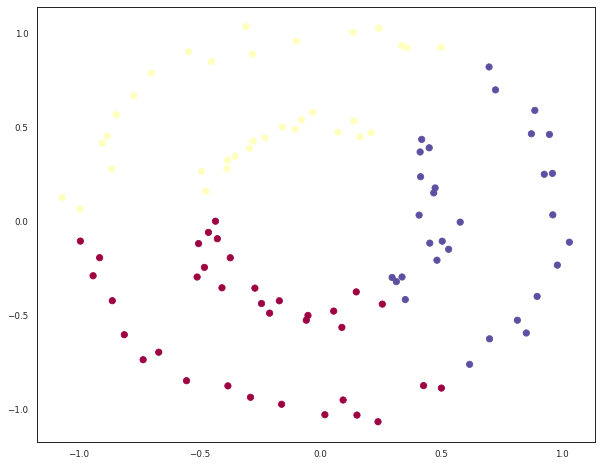

In [308]:
if __name__ == "__main__":
    np.random.seed(10)
    num_clusters = 3
    X, _ = make_blobs(n_samples=100, n_features=2, centers=num_clusters)
    d = noisy_circles_pd[['x','y']]
    Kmeans = KMeansClustering(d, num_clusters)
    y_pred = Kmeans.fit(d.to_numpy())

The results from the KMEAN algorithm implemented from scratch and the sklearn KMEAN algorithm are exactly identical for all the datasets. 

# Comments (optional feedback to the course instructors)
Here, please, leave your comments regarding the homework, possibly answering the following questions: 
* how much time did you spend on this homework?
* was it too hard/easy for you?
* what would you suggest to add or remove?
* anything else you would like to tell us

Your comments: Can we please have more material to help us in the howework? This is something that I'm really struggling with. Thanks!